# Prédiction de la courbe de rétention d'eau des sols à partir de données géotechniques 

## Imports

In [232]:
import pandas as pds
import zipfile
import pyodbc
import pandas as pd
import zipfile
import subprocess
import re
import os

## Récupération des données

In [233]:
zip_file_path = 'unsoda.zip'
extract_to_path = 'data/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [234]:
# mdb file format veut juste dire que c'est une base de donnees sur access

In [235]:
mdb_file_path = 'data/unsoda.mdb'
conn_str = (
    r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    f'DBQ={mdb_file_path};'
)
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()


In [236]:
table_names = [table.table_name for table in cursor.tables(tableType='TABLE')]
table_names

['a_database_description',
 'aggregate_size_distribution',
 'code_filter',
 'comment_field_general',
 'comment_field_hydr_cond',
 'comment_field_sat_cond',
 'comment_field_wat_ret',
 'comment_general',
 'comment_lab_general',
 'comment_lab_hydr_cond',
 'comment_lab_sat_cond',
 'comment_lab_wat_ret',
 'comment_soil_properties',
 'contact_person',
 'field_drying_h-k',
 'field_drying_h-t',
 'field_drying_t-d',
 'field_drying_t-k',
 'field_wetting_h-k',
 'field_wetting_h-t',
 'field_wetting_t-d',
 'field_wetting_t-k',
 'general',
 'lab_drying_h-k',
 'lab_drying_h-t',
 'lab_drying_t-d',
 'lab_drying_t-k',
 'lab_wetting_h-k',
 'lab_wetting_h-t',
 'lab_wetting_t-d',
 'lab_wetting_t-k',
 'methodology',
 'mineralogy',
 'only_codes',
 'particle_size',
 'publication',
 'soil_properties',
 'summary_of_tabular_data']

In [237]:
len(table_names)

38

In [238]:
for table_name in table_names:
    sql = f'SELECT * FROM [{table_name}]'
    try:
        df = pd.read_sql_query(sql, conn)
        df.to_csv(f'datatables/{table_name}.csv', index=False)
    except Exception as e:
        print(f"Error exporting table {table_name}: {e}")


C:\Users\Rania\AppData\Local\Temp\ipykernel_24392\2713566114.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


In [239]:
csv_directory = 'datatables/'

dataframes = {}

for table_name in table_names:
    csv_path = os.path.join(csv_directory, f'{table_name}.csv')
    try:
        df = pd.read_csv(csv_path)
        dataframes[table_name] = df
    except Exception as e:
        print(f"Error loading table {table_name} from CSV: {e}")

common_columns_list = []

for i, (table_name1, df1) in enumerate(dataframes.items()):
    for table_name2, df2 in list(dataframes.items())[i+1:]:
        common_columns = set(df1.columns) & set(df2.columns)
        for column in common_columns:
            common_columns_list.append((table_name1, table_name2, column))

common_columns_list

[('aggregate_size_distribution', 'field_drying_h-k', 'code'),
 ('aggregate_size_distribution', 'field_drying_h-t', 'code'),
 ('aggregate_size_distribution', 'field_drying_t-d', 'code'),
 ('aggregate_size_distribution', 'field_drying_t-k', 'code'),
 ('aggregate_size_distribution', 'field_wetting_h-k', 'code'),
 ('aggregate_size_distribution', 'field_wetting_h-t', 'code'),
 ('aggregate_size_distribution', 'field_wetting_t-d', 'code'),
 ('aggregate_size_distribution', 'field_wetting_t-k', 'code'),
 ('aggregate_size_distribution', 'general', 'code'),
 ('aggregate_size_distribution', 'lab_drying_h-k', 'code'),
 ('aggregate_size_distribution', 'lab_drying_h-t', 'code'),
 ('aggregate_size_distribution', 'lab_drying_t-d', 'code'),
 ('aggregate_size_distribution', 'lab_drying_t-k', 'code'),
 ('aggregate_size_distribution', 'lab_wetting_h-k', 'code'),
 ('aggregate_size_distribution', 'lab_wetting_h-t', 'code'),
 ('aggregate_size_distribution', 'lab_wetting_t-d', 'code'),
 ('aggregate_size_distri

In [240]:
possible_common_columns = [tup[2] for tup in common_columns_list]
set(possible_common_columns)

{'code',
 'comment_fhc_ID',
 'comment_field_ID',
 'comment_fsc_ID',
 'comment_fwr_ID',
 'comment_general_ID',
 'comment_lab_ID',
 'comment_lhc_ID',
 'comment_lsc_ID',
 'comment_lwr_ID',
 'comment_soilprop_ID',
 'conductivity',
 'contact_person_ID',
 'diffusivity',
 'preshead',
 'publication_ID',
 'texture',
 'theta'}

## Analyse préliminaire des données

### Relations entre les tables

In [241]:
import os

schema_folder = 'schema'
if not os.path.exists(schema_folder):
    os.makedirs(schema_folder)


In [242]:
'''import matplotlib.pyplot as plt
import networkx as nx

def create_and_save_plot(table, related_tables, schema_folder):
    G = nx.Graph()
    G.add_node(table)
    for rel_table, common_attr in related_tables.items():
        G.add_edge(table, rel_table, label=common_attr)
    
    pos = nx.spring_layout(G)
    fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, node_shape='s', node_color='skyblue', alpha=0.6, ax=ax)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color="gray", ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green', ax=ax)

    plt.axis('off')
    plt.title(f"Schema of {table} Relationships")
    plt.savefig(f"{schema_folder}/{table}_schema.png")
    plt.close()

from collections import defaultdict
relationships = defaultdict(dict)
for table1, table2, common_attr in common_columns_list:
    relationships[table1][table2] = common_attr
    relationships[table2][table1] = common_attr 

for table, related_tables in relationships.items():
    create_and_save_plot(table, related_tables, schema_folder)
'''

'import matplotlib.pyplot as plt\nimport networkx as nx\n\ndef create_and_save_plot(table, related_tables, schema_folder):\n    G = nx.Graph()\n    G.add_node(table)\n    for rel_table, common_attr in related_tables.items():\n        G.add_edge(table, rel_table, label=common_attr)\n    \n    pos = nx.spring_layout(G)\n    fig, ax = plt.subplots(figsize=(10, 6))\n    nx.draw_networkx_nodes(G, pos, node_shape=\'s\', node_color=\'skyblue\', alpha=0.6, ax=ax)\n    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color="gray", ax=ax)\n    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)\n\n    edge_labels = nx.get_edge_attributes(G, \'label\')\n    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color=\'green\', ax=ax)\n\n    plt.axis(\'off\')\n    plt.title(f"Schema of {table} Relationships")\n    plt.savefig(f"{schema_folder}/{table}_schema.png")\n    plt.close()\n\nfrom collections import defaultdict\nrelationships = defaultdict(dict)\nfor table1, table2, com

### Analyse des donnees

In [243]:
'''import pandas as pd
import os
import matplotlib.pyplot as plt

tables_folder = 'tables'
if not os.path.exists(tables_folder):
    os.makedirs(tables_folder)

common_attributes = set()
for table1, table2, column in common_columns_list:
    common_attributes.add((table1, column))
    common_attributes.add((table2, column))

for table_name in table_names:
    csv_path = os.path.join(csv_directory, f'{table_name}.csv')
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)

        fig, ax = plt.subplots(figsize=(10, len(df.columns) * 0.6 + 2))  
        ax.axis('off')
        plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  

        cols = ['Attribute', 'Type', 'Unique', 'Duplicates', 'Missing']
        cell_text = []
        cell_colors = []
        for col in df.columns:
            unique_values = df[col].nunique()
            duplicates = len(df) - unique_values - df[col].isnull().sum()
            missing = df[col].isnull().sum()
            attr_type = str(df[col].dtype)
            is_common = (table_name, col) in common_attributes
            prefix = '*' if is_common else ''
            cell_text.append([prefix + col, attr_type, unique_values, duplicates, missing])
            cell_colors.append(['#FFDDC1' if is_common else 'white'] * 5)

        table = ax.table(cellText=cell_text, colLabels=cols, loc='center', cellLoc='center', cellColours=cell_colors)
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.2)

        plt.title(f"Attributes of {table_name}", pad=20)
        plt.savefig(os.path.join(tables_folder, f"{table_name}_attributes.png"), bbox_inches='tight')
        plt.close()'''


'import pandas as pd\nimport os\nimport matplotlib.pyplot as plt\n\ntables_folder = \'tables\'\nif not os.path.exists(tables_folder):\n    os.makedirs(tables_folder)\n\ncommon_attributes = set()\nfor table1, table2, column in common_columns_list:\n    common_attributes.add((table1, column))\n    common_attributes.add((table2, column))\n\nfor table_name in table_names:\n    csv_path = os.path.join(csv_directory, f\'{table_name}.csv\')\n    if os.path.exists(csv_path):\n        df = pd.read_csv(csv_path)\n\n        fig, ax = plt.subplots(figsize=(10, len(df.columns) * 0.6 + 2))  \n        ax.axis(\'off\')\n        plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  \n\n        cols = [\'Attribute\', \'Type\', \'Unique\', \'Duplicates\', \'Missing\']\n        cell_text = []\n        cell_colors = []\n        for col in df.columns:\n            unique_values = df[col].nunique()\n            duplicates = len(df) - unique_values - df[col].isnull().sum()\n            missing = df[c

### Visualisation des donnees

In [244]:
#! /usr/bin/env python3

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

# ploting option
plt.rcParams['figure.figsize'] = [12.94, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["figure.autolayout"] = True
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10

SAVE_FIGS = True

# path to folder containing csv files
SUBDIR = 'datatables/'

# if one soil data are studied
CODE = 1011

# read data files
df_soil = pd.read_csv(SUBDIR + "soil_properties.csv")
# sat permeability from cm/d to m/s
df_soil.k_sat = df_soil.k_sat.apply(lambda x: x/86400/100)

df_gsd = pd.read_csv(SUBDIR + "particle_size.csv")
# particle_size from µm to mm
df_gsd.particle_size = df_gsd.particle_size.apply(lambda x: x/1000)

df_wrc = pd.read_csv(SUBDIR + "lab_drying_h-t.csv")
# preshead from cm_H20 to kPa
df_wrc.preshead = df_wrc.preshead.apply(lambda x: x/10) 

print('Soil properties:')
print(df_soil[df_soil.code == CODE])



Soil properties:
   code  bulk_density  particle_density  porosity  OM_content     k_sat  \
1  1011          1.52              2.68      0.43         NaN  0.000036   

   theta_sat  CEC  pH  electrolyte_level  SAR  ESP  EC  free_Fe_Al_oxide  
1        NaN  NaN NaN                NaN  NaN  NaN NaN               NaN  


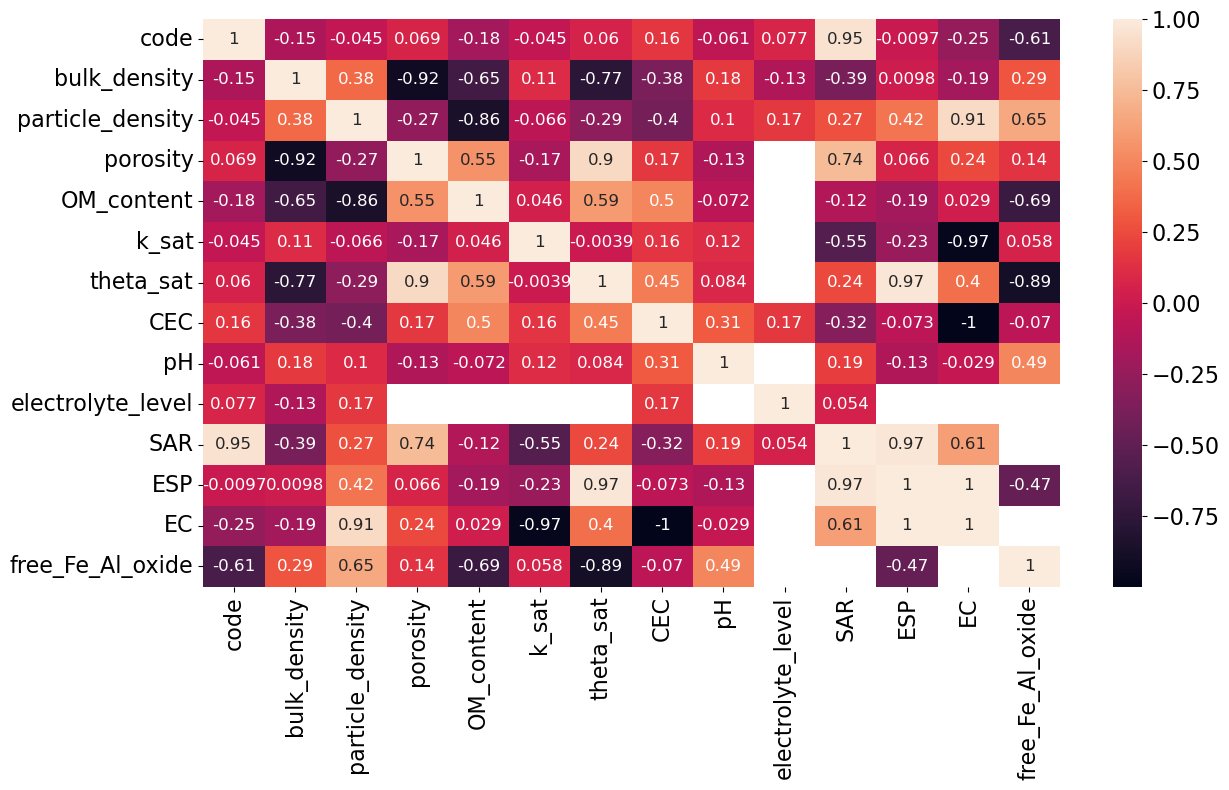

In [245]:
# correlation between basic variables
# df_soil.corr()
import seaborn as sns    # Allows for easy plotting of heatmaps
sns_plt = sns.heatmap(df_soil.corr(), annot=True, annot_kws={"fontsize":12})
if SAVE_FIGS:
    plt.savefig("fig_corr.png")
    
else:
    plt.show()
plt.show()
plt.close()

# NB : not enough data for EC to say something about high correlation with k_sat

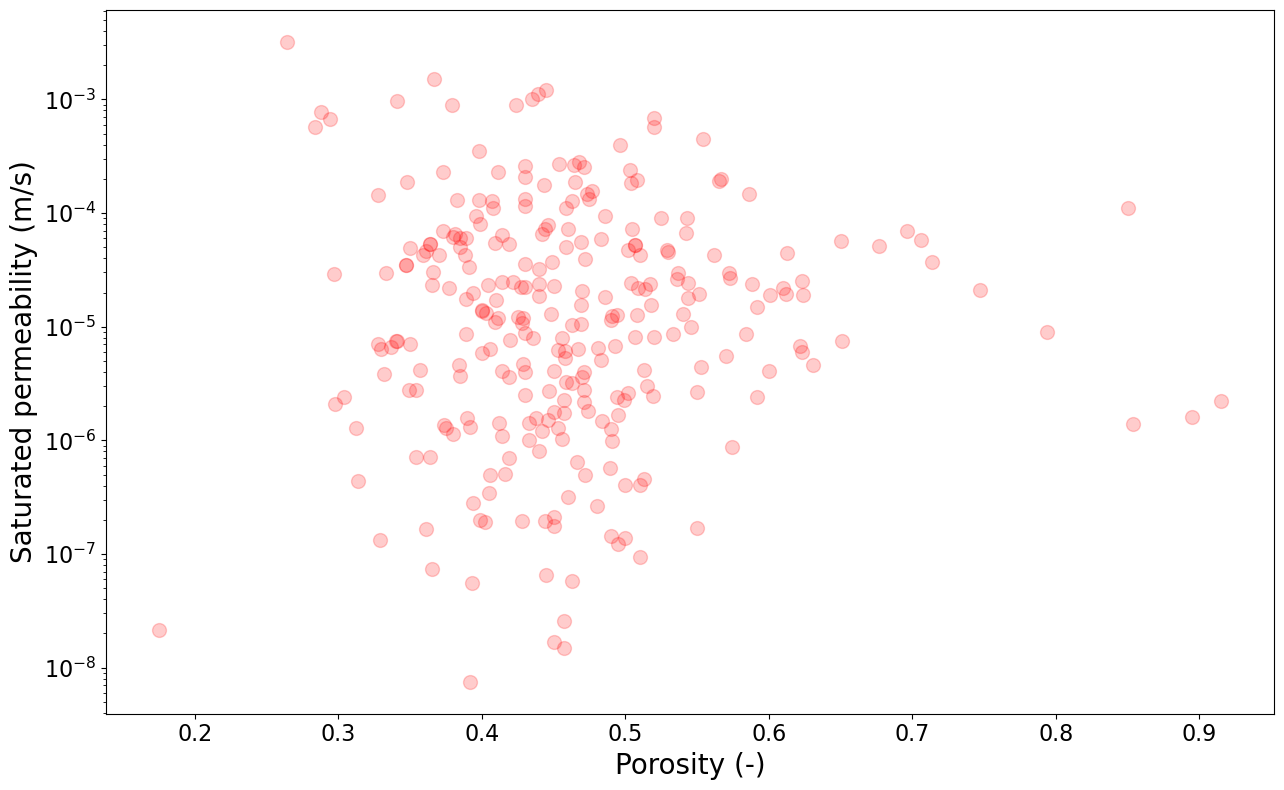

In [246]:
# porosity vs permeability
df_soil.plot(x="porosity", y="k_sat", style='ro', logy=True, alpha=0.2,
    legend=False, xlabel="Porosity (-)", ylabel="Saturated permeability (m/s)")
if SAVE_FIGS:
    plt.savefig("n-k_sat.pdf")
else:
    plt.show()
plt.show()
plt.close()

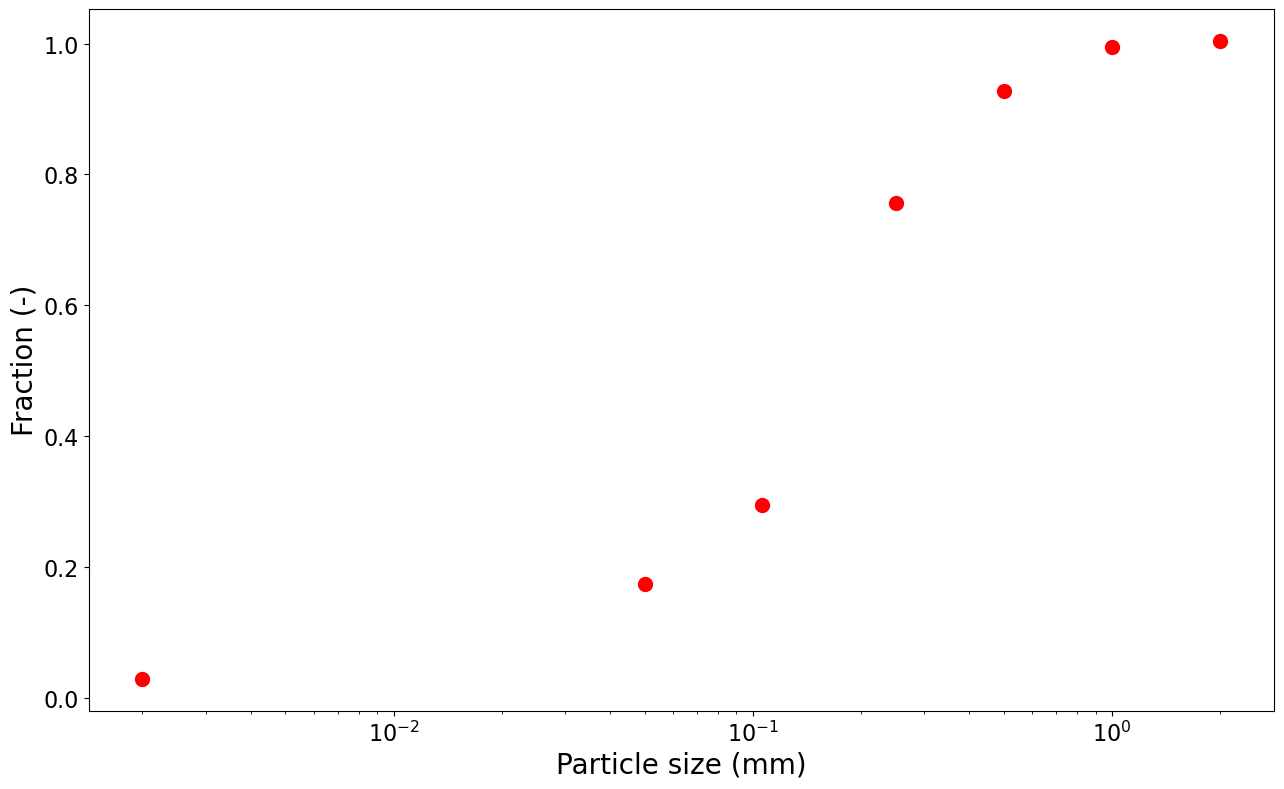

In [247]:
# plotting gsd for CODE
df_gsd[df_gsd.code == CODE].plot(x="particle_size", y="particle_fraction", logx=True, style='ro',
                                 legend=False, xlabel="Particle size (mm)", ylabel="Fraction (-)")
if SAVE_FIGS:
    plt.savefig("fig_gsd.pdf")
else:
    plt.show()
plt.show()
plt.close()

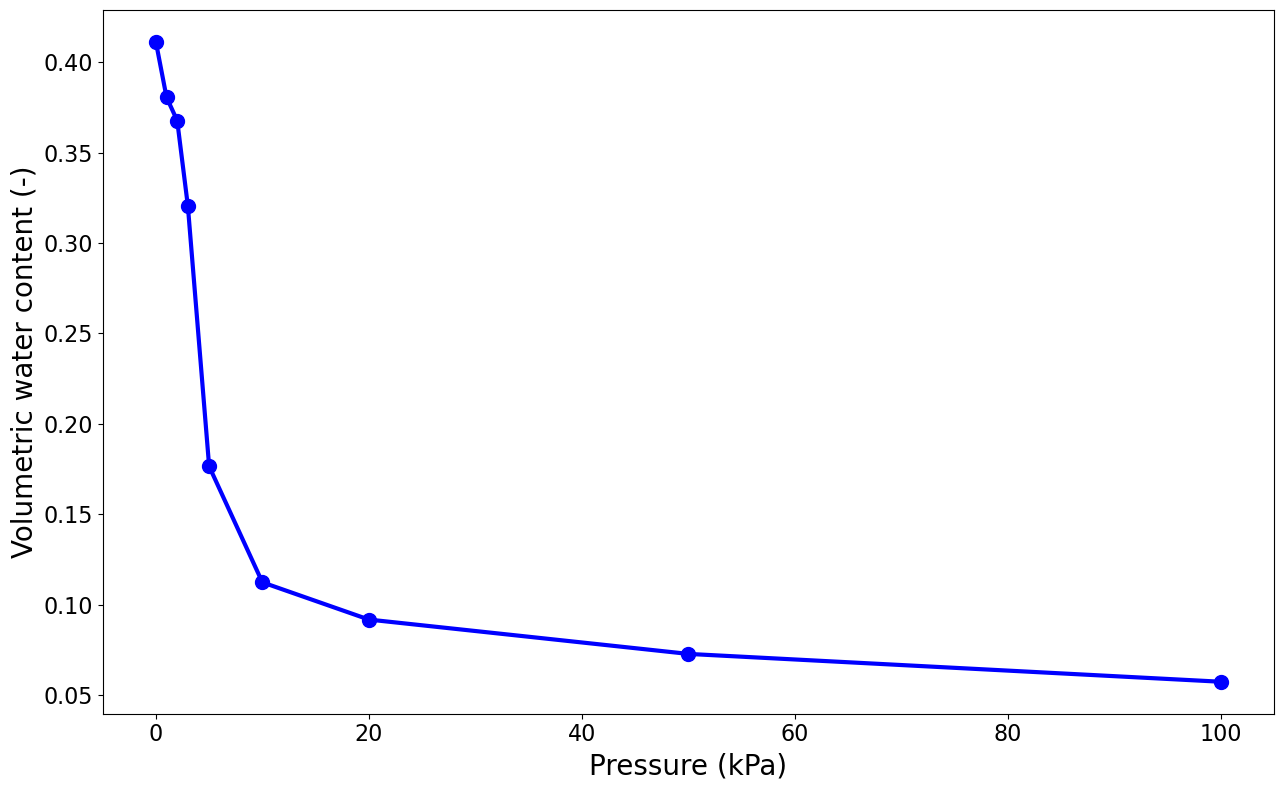

In [248]:
 #plotting water retention curve for CODE
df_wrc[df_wrc.code == CODE].plot(x="preshead", y="theta", style='-bo',
                                 legend=False, xlabel="Pressure (kPa)", ylabel="Volumetric water content (-)")
if SAVE_FIGS:
    plt.savefig("fig_wrc.pdf")
else:
    plt.show()
plt.show()
plt.close()

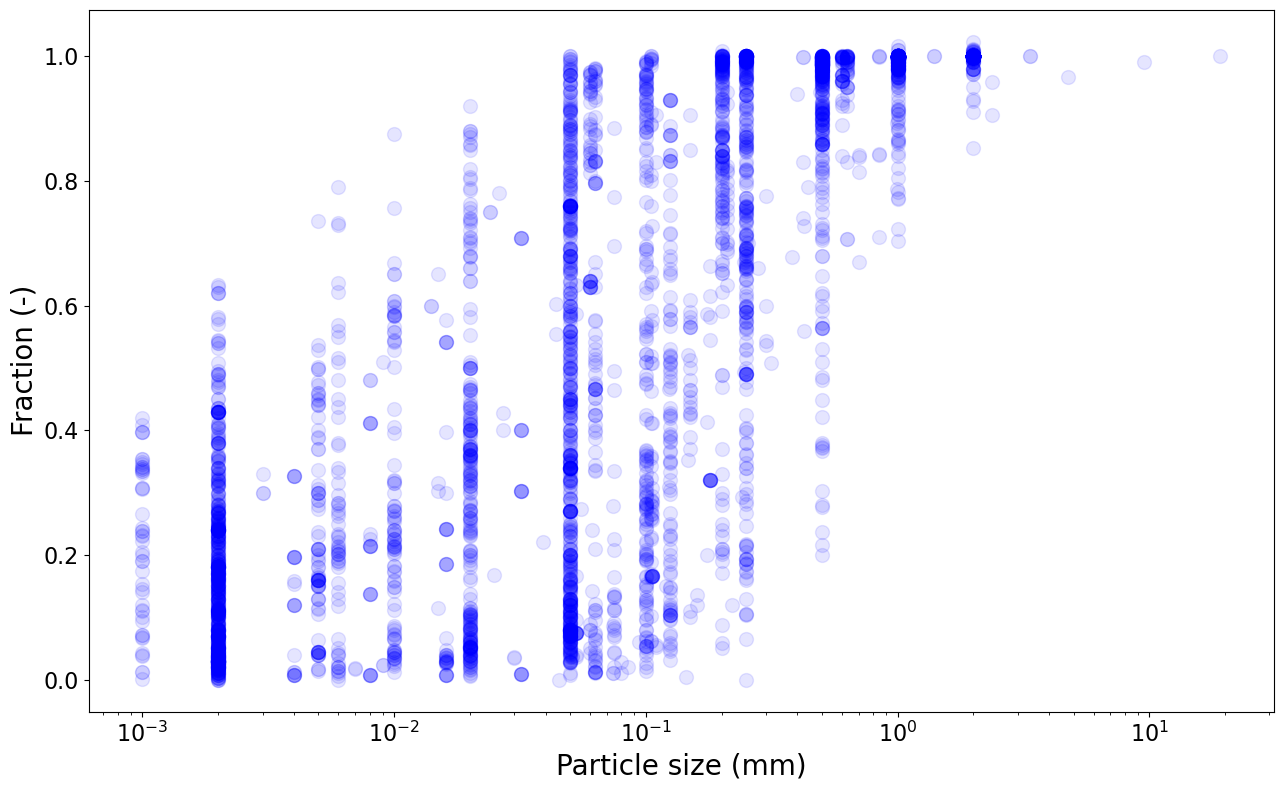

In [249]:
#plotting all gsd curves
df_gsd.plot(x="particle_size", y="particle_fraction", logx=True, style='bo', alpha=0.1,
                                 legend=False, xlabel="Particle size (mm)", ylabel="Fraction (-)")
if SAVE_FIGS:
    plt.savefig("fig_gsd_all.pdf")
else:
    plt.show()
plt.show()
plt.close()

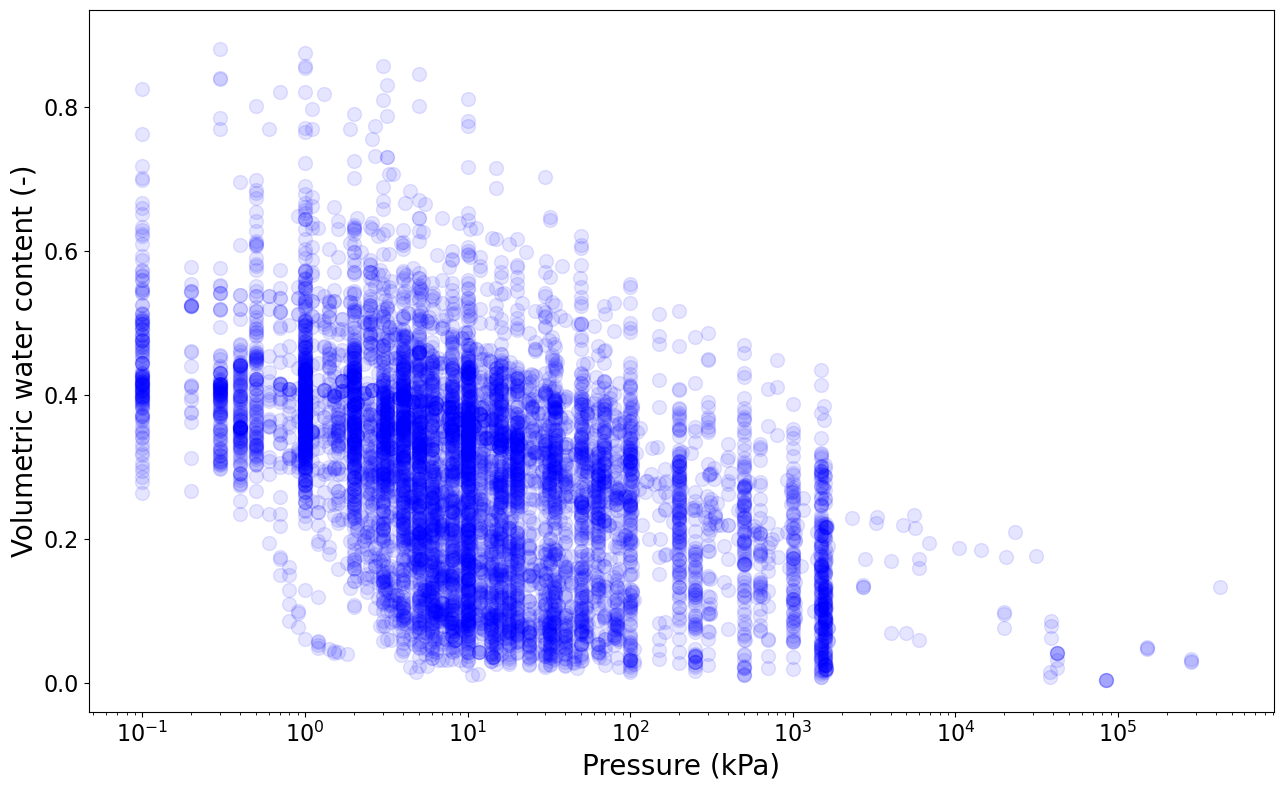

In [250]:
# plotting all water retention curves
df_wrc.plot(x="preshead", y="theta", logx=True, style='bo', alpha=0.1,
            legend=False, xlabel="Pressure (kPa)", ylabel="Volumetric water content (-)")
if SAVE_FIGS:
    plt.savefig("fig_wrc_all.pdf")
else:
    plt.show()
plt.show()
plt.close()

In [251]:
df_gen = pd.read_csv(SUBDIR + "general.csv")
print("df_gen.count()")
print(df_gen.count())
df_sand = df_gen[df_gen["texture"].isin(["sand"])]
df_sand = df_gen[df_gen["texture"].astype(str).str.contains("sand")]

# retrieve list of codes for a given soil texture
codes = df_gen[df_gen["texture"].isin(["sand"])].code.to_numpy()

df_gen.count()
code                 790
family               603
series               790
texture              776
structure            347
depth_upper          685
depth_lower          685
horizon              651
depth_gwater         132
location             758
site_ID              688
annual_rain          438
avetemp_jan          308
avetemp_jul          309
date                 613
publication_ID       790
keyword              735
contact_person_ID    790
rating               313
rated_by             258
dtype: int64


In [252]:
## see other textures
df_gen["texture"].value_counts()

texture
sand               184
silt loam          140
sandy loam         132
loam                69
loamy sand          60
sandy clay loam     52
clay                39
clay loam           36
silty clay loam     30
silty clay          24
sandy clay           3
silt                 3
Tuffaceous Rock      1
silty loam           1
sandy                1
sandy laom           1
Name: count, dtype: int64

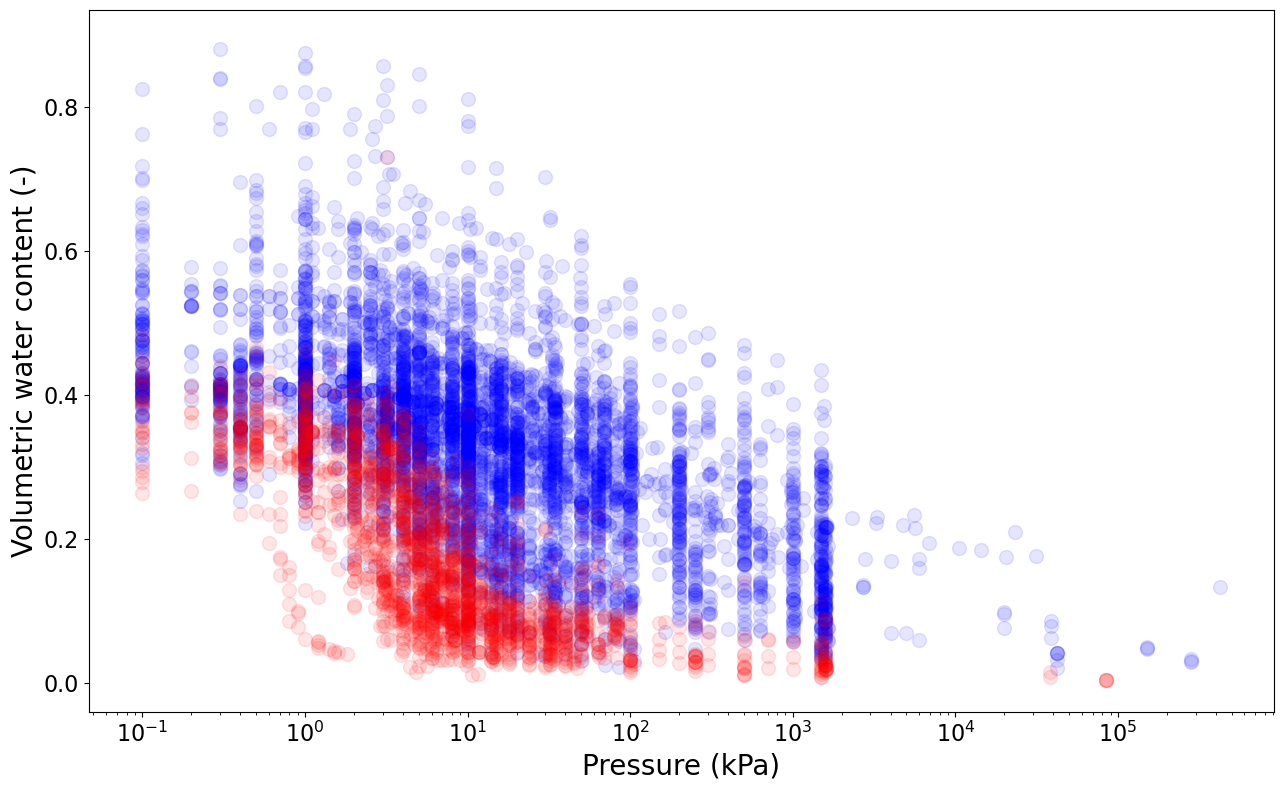

In [323]:
# plotting water retention curves for sands
ax = df_wrc[df_wrc.code.isin(codes) == False].plot(x="preshead", y="theta", style='bo', logx=True, alpha=0.1,
            legend=False, xlabel="Pressure (kPa)", ylabel="Volumetric water content (-)")
df_wrc[df_wrc.code.isin(codes)].plot(ax=ax,x="preshead", y="theta", style='ro', logx=True, alpha=0.1,
            legend=False, xlabel="Pressure (kPa)", ylabel="Volumetric water content (-)")
if SAVE_FIGS:
    plt.savefig("fig_wrc_select.pdf")
else:
    plt.show()
plt.show()
plt.close()

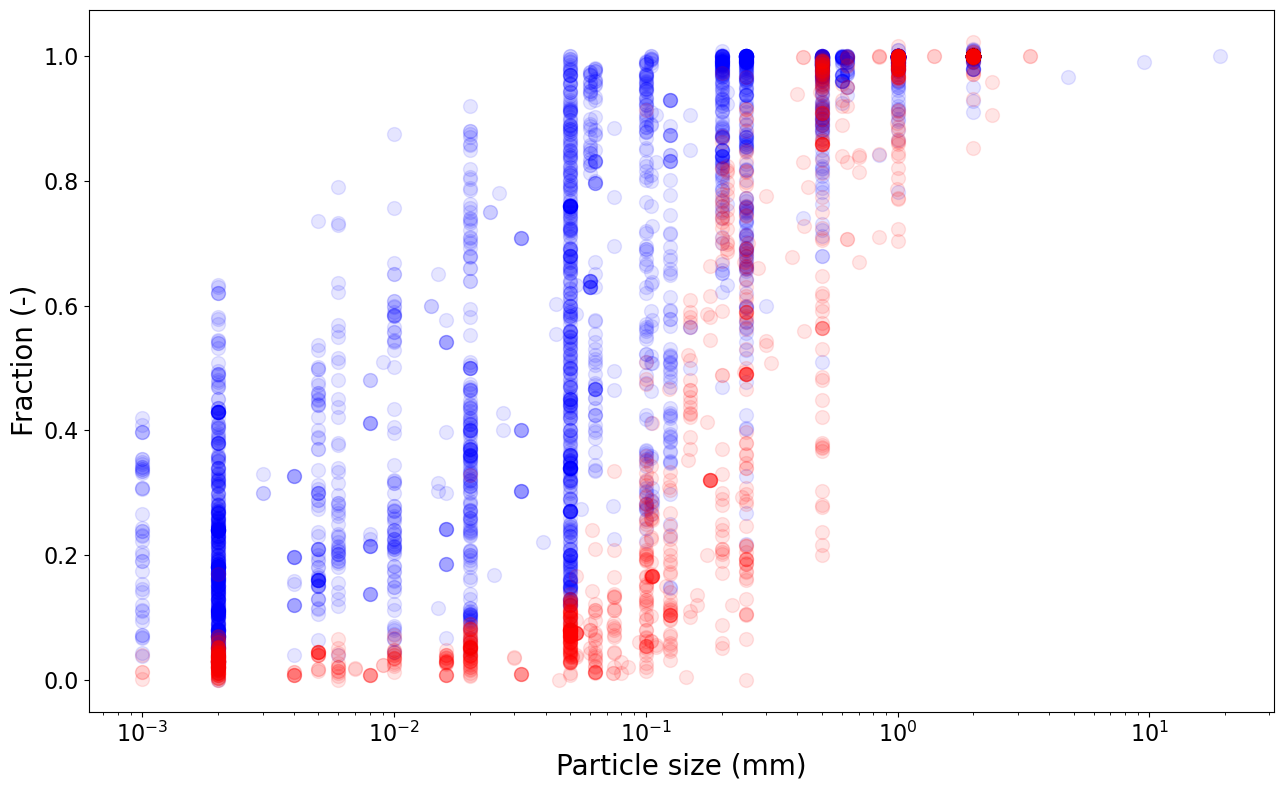

In [324]:
# plotting GSD for sands
ax = df_gsd[df_gsd.code.isin(codes) == False].plot(x="particle_size", y="particle_fraction", logx=True, style='bo', alpha=0.1,
            legend=False, xlabel="Particle size (mm)", ylabel="Fraction (-)")
ax = df_gsd[df_gsd.code.isin(codes)].plot(ax=ax, x="particle_size", y="particle_fraction", logx=True, style='ro', alpha=0.1,
            legend=False, xlabel="Particle size (mm)", ylabel="Fraction (-)")
if SAVE_FIGS:
    plt.savefig("fig_gsd_select.pdf")
else:
    plt.show()
plt.show()
plt.close()

In [255]:
# Selecting values for GSD curves (cumulative percentages for 7 values)
gsd_names = ['P2', 'P50', 'P100', 'P250', 'P500', 'P1000', 'P2000']
gsd_points = pd.Series([0.002, 0.05, 0.1, 0.25, 0.5, 1, 2])

#codes = [1110] #codes[0:2]

# counting the number of lines
selec_len = df_wrc[df_wrc.code.isin(codes)].preshead.count()
print('selec_len = ' + selec_len.astype(str))
#selec_len2 = df_wrc[df_wrc.code.isin(codes)].theta.count()
#print('selec_len2 = ' + selec_len2.astype(str))

df_select = pd.DataFrame(
    index=np.arange(selec_len), columns=['code'] + gsd_names + ['rho', 'suction', 'theta']
)
#print(df_select)
#print(df_select.describe())

icount = 0
for icode in codes:
#    print(icode)
    tmp1 = df_wrc.loc[df_wrc.code.isin([icode]),['preshead', 'theta']]
    if tmp1.count()['preshead'] != tmp1.count()['theta']:
        sys.exit("Length mismatch in wrc")
    tmp2 = df_gsd.loc[(df_gsd.code.isin([icode])),['particle_size', 'particle_fraction']]
    if tmp2.count()['particle_size'] != tmp2.count()['particle_fraction']:
        sys.exit("Length mismatch in gsd")
    if (tmp1.count()['preshead'] > 0) and (tmp2.particle_size.count() > 0):
        if (tmp2.particle_size.size != 7) or ((tmp2.particle_size.size == 7) and ((tmp2.particle_size.values != gsd_points.values).any())):
#            print("correction to gsd of: " + str(icode))
            f = interpolate.interp1d(tmp2.particle_size,tmp2.particle_fraction,
                                        bounds_error=False,fill_value=(0.,1.))
            tmp2 = pd.DataFrame(
                {
                'particle_size': gsd_points.values,
                'particle_fraction': f(gsd_points),
                }
            )        
        for iwrc in range(tmp1.count()['preshead']): #count() better than len() to exclude wrc with NaN values
            df_select.at[icount,'code'] = icode
            for ipoints in range(len(gsd_names)):
                tmp = tmp2[tmp2.particle_size == gsd_points[ipoints]].particle_fraction
                if len(tmp) > 0:
                    df_select.at[icount,gsd_names[ipoints]] = tmp.values[0]
            tmp = df_soil[df_soil.code.isin([icode])].bulk_density
            if len(tmp) > 0:
                df_select.at[icount,'rho'] = tmp.values[0]
            if len([tmp1.preshead.values[iwrc]]) > 0:
                df_select.at[icount,'suction'] = tmp1.preshead.values[iwrc]
            if len([tmp1.theta.values[iwrc]]) > 0:
                df_select.at[icount,'theta'] = tmp1.theta.values[iwrc]
            icount += 1

df_select.head()

selec_len = 2120


,code,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta
0,1014,0.02,0.13,0.2425,0.743,0.916,0.985,0.997,1.53,0.0,0.3615
1,1014,0.02,0.13,0.2425,0.743,0.916,0.985,0.997,1.53,2.0,0.324
2,1014,0.02,0.13,0.2425,0.743,0.916,0.985,0.997,1.53,3.0,0.2655
3,1014,0.02,0.13,0.2425,0.743,0.916,0.985,0.997,1.53,4.0,0.1945
4,1014,0.02,0.13,0.2425,0.743,0.916,0.985,0.997,1.53,5.0,0.16


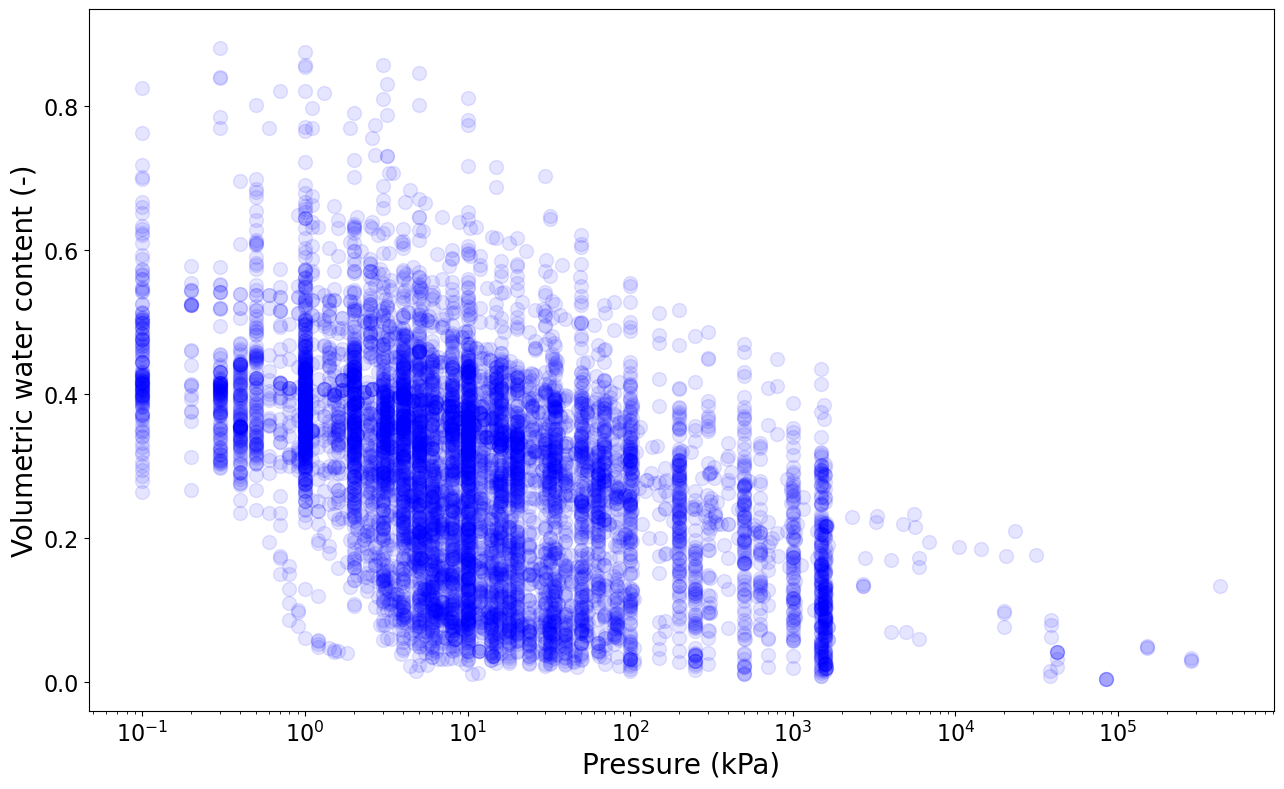

In [256]:
df_wrc.plot(x="preshead", y="theta", logx=True, style='bo', alpha=0.1,
            legend=False, xlabel="Pressure (kPa)", ylabel="Volumetric water content (-)")
(df_select[gsd_names].T).plot(legend=False)
if SAVE_FIGS:
    plt.savefig("fig_gsd_select_corr.pdf")
else:
    plt.show()
plt.close()

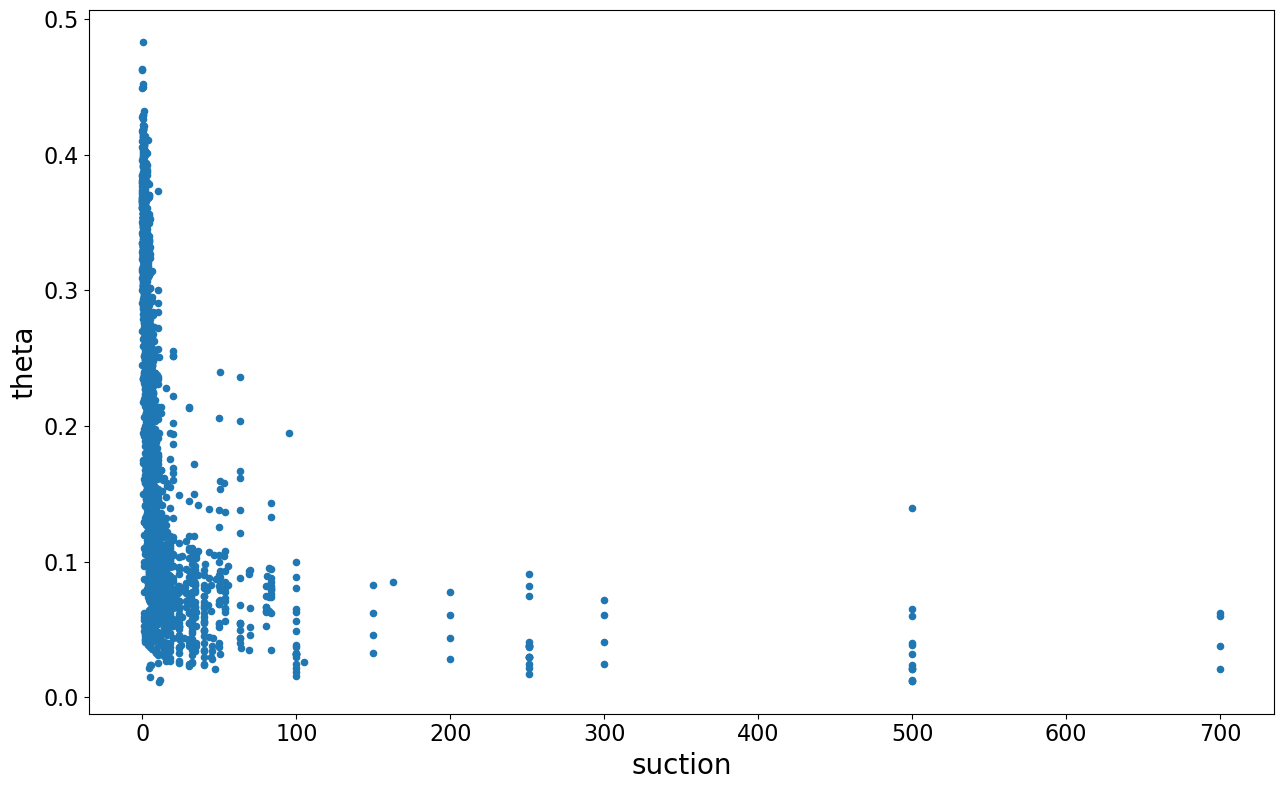

In [257]:
df_select = df_select[df_select['theta']<0.7]
df_select = df_select[df_select['suction']<10000]
df_select = df_select[(df_select['theta']<0.7) & (df_select['suction']<1000)]
df_select.plot.scatter(x='suction', y='theta',legend=False)
if SAVE_FIGS:
    plt.savefig("fig_wrc_select_corr.pdf")
else:
    plt.show()
plt.show()
plt.close()

In [258]:
#outlier
df_select[(df_select['theta'] > 0.7) & (df_select['code'] == 1460)]

,code,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta


In [259]:
df_select.to_csv(r'data_clean0.csv', index=False, header=True)
df_select.dropna(how="any").to_csv(r'data_clean.csv', index=False, header=True)
print('Data exported to csv files')

Data exported to csv files


### Feature Engineering

In [260]:
## The teacher used soil-properties, particle-size, lab-drying-h-t and general csvs to get good features. i will try to exploite more features.

In [261]:
import os
import pandas as pd

csv_directory = 'datatables/'
dataframes = {}

for table_name in table_names:
    csv_path = os.path.join(csv_directory, f'{table_name}.csv')
    try:
        df = pd.read_csv(csv_path)
        dataframes[table_name] = df
    except Exception as e:
        print(f"Error loading table {table_name} from CSV: {e}")

exact_common_attributes = []

for i, (table_name1, df1) in enumerate(dataframes.items()):
    for table_name2, df2 in list(dataframes.items())[i+1:]:
        common_columns = set(df1.columns) & set(df2.columns)
        for column in common_columns:
            if set(df1[column]).issubset(set(df2[column])) or set(df2[column]).issubset(set(df1[column])):
                exact_common_attributes.append((table_name1, table_name2, column))

exact_common_attributes

[('aggregate_size_distribution', 'field_drying_h-k', 'code'),
 ('aggregate_size_distribution', 'field_drying_h-t', 'code'),
 ('aggregate_size_distribution', 'field_drying_t-d', 'code'),
 ('aggregate_size_distribution', 'field_drying_t-k', 'code'),
 ('aggregate_size_distribution', 'field_wetting_h-k', 'code'),
 ('aggregate_size_distribution', 'field_wetting_h-t', 'code'),
 ('aggregate_size_distribution', 'field_wetting_t-d', 'code'),
 ('aggregate_size_distribution', 'field_wetting_t-k', 'code'),
 ('aggregate_size_distribution', 'general', 'code'),
 ('aggregate_size_distribution', 'lab_drying_h-k', 'code'),
 ('aggregate_size_distribution', 'lab_drying_h-t', 'code'),
 ('aggregate_size_distribution', 'lab_drying_t-d', 'code'),
 ('aggregate_size_distribution', 'lab_drying_t-k', 'code'),
 ('aggregate_size_distribution', 'lab_wetting_h-k', 'code'),
 ('aggregate_size_distribution', 'lab_wetting_h-t', 'code'),
 ('aggregate_size_distribution', 'lab_wetting_t-d', 'code'),
 ('aggregate_size_distri

In [262]:
## On commence par ignorer les tables de jointure.
common_attributes_set = set([attr for _, _, attr in exact_common_attributes])

tables_with_only_common_attributes = []
tables_with_non_common_attributes = []

for table_name, df in dataframes.items():
    table_attributes = set(df.columns)
    
    if table_attributes.issubset(common_attributes_set):
        tables_with_only_common_attributes.append(table_name)
    else:
        tables_with_non_common_attributes.append(table_name)

In [263]:
# voir combien on a elimineeee
len(tables_with_only_common_attributes)

2

In [264]:
tables_with_only_common_attributes

['code_filter', 'methodology']

In [265]:
# let's check out what we have left 
tables_with_non_common_attributes

['a_database_description',
 'aggregate_size_distribution',
 'comment_field_general',
 'comment_field_hydr_cond',
 'comment_field_sat_cond',
 'comment_field_wat_ret',
 'comment_general',
 'comment_lab_general',
 'comment_lab_hydr_cond',
 'comment_lab_sat_cond',
 'comment_lab_wat_ret',
 'comment_soil_properties',
 'contact_person',
 'field_drying_h-k',
 'field_drying_h-t',
 'field_drying_t-d',
 'field_drying_t-k',
 'field_wetting_h-k',
 'field_wetting_h-t',
 'field_wetting_t-d',
 'field_wetting_t-k',
 'general',
 'lab_drying_h-k',
 'lab_drying_h-t',
 'lab_drying_t-d',
 'lab_drying_t-k',
 'lab_wetting_h-k',
 'lab_wetting_h-t',
 'lab_wetting_t-d',
 'lab_wetting_t-k',
 'mineralogy',
 'only_codes',
 'particle_size',
 'publication',
 'soil_properties',
 'summary_of_tabular_data']

In [266]:
# here we take off commentary tables because they are irrelevant for our regression prediction
tables_tokeep = [table for table in tables_with_non_common_attributes if not table.startswith('comment_')]
tables_tokeep

['a_database_description',
 'aggregate_size_distribution',
 'contact_person',
 'field_drying_h-k',
 'field_drying_h-t',
 'field_drying_t-d',
 'field_drying_t-k',
 'field_wetting_h-k',
 'field_wetting_h-t',
 'field_wetting_t-d',
 'field_wetting_t-k',
 'general',
 'lab_drying_h-k',
 'lab_drying_h-t',
 'lab_drying_t-d',
 'lab_drying_t-k',
 'lab_wetting_h-k',
 'lab_wetting_h-t',
 'lab_wetting_t-d',
 'lab_wetting_t-k',
 'mineralogy',
 'only_codes',
 'particle_size',
 'publication',
 'soil_properties',
 'summary_of_tabular_data']

In [267]:
# here we take off more irrelevant tables like only_codes, table descriptions, summary of tabulr data, publication, contact person...
relevant_tables = [table for table in tables_tokeep if table not in [
    'a_database_description',
    'contact_person',
    'only_codes',
    'publication',
    'summary_of_tabular_data'
]]
len(relevant_tables)

21

In [268]:
relevant_tables

['aggregate_size_distribution',
 'field_drying_h-k',
 'field_drying_h-t',
 'field_drying_t-d',
 'field_drying_t-k',
 'field_wetting_h-k',
 'field_wetting_h-t',
 'field_wetting_t-d',
 'field_wetting_t-k',
 'general',
 'lab_drying_h-k',
 'lab_drying_h-t',
 'lab_drying_t-d',
 'lab_drying_t-k',
 'lab_wetting_h-k',
 'lab_wetting_h-t',
 'lab_wetting_t-d',
 'lab_wetting_t-k',
 'mineralogy',
 'particle_size',
 'soil_properties']

In [269]:
import pandas as pd
import os
folder_path = 'datatables'

output_file_path = 'missing_values_report.txt'

with open(output_file_path, 'w') as report_file:
    for table_name in relevant_tables:
        csv_path = os.path.join(folder_path, f'{table_name}.csv')
        try:
            df = pd.read_csv(csv_path)
            missing_ratio = df.isnull().sum() / len(df) * 100
            report_content = f"--- Missing Values Ratio in {table_name} ---\n{missing_ratio}\n\n" + "="*50 + "\n\n"
            report_file.write(report_content)
        except Exception as e:
            error_message = f"Error processing table {table_name}: {e}\n"
            report_file.write(error_message)

print(f"Missing values report saved to {output_file_path}")


Missing values report saved to missing_values_report.txt


In [270]:
df1 = pd.read_csv(os.path.join('datatables','soil_properties.csv')) 
df1.head()

,code,bulk_density,particle_density,porosity,OM_content,k_sat,theta_sat,CEC,pH,electrolyte_level,SAR,ESP,EC,free_Fe_Al_oxide
0,1010,1.64,2.64,0.394,0.01,171.1,0.384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1011,1.52,2.68,0.430,NaN,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1012,1.40,2.66,0.440,NaN,207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1013,1.49,2.67,0.440,NaN,161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1014,1.53,2.76,0.450,NaN,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
df2 = pd.read_csv(os.path.join('datatables','particle_size.csv')) 
df2.head()

,code,particle_size,particle_fraction
0,1010,2.0,0.030
1,1010,50.0,0.170
2,1010,106.0,0.279
3,1010,250.0,0.735
4,1010,500.0,0.921


In [272]:
df3 = pd.read_csv(os.path.join('datatables','lab_drying_h-t.csv')) 
df3.head()

,code,preshead,theta
0,1010,0.0,0.380
1,1010,10.0,0.348
2,1010,20.0,0.328
3,1010,30.0,0.319
4,1010,50.0,0.212


In [273]:
df4 = pd.read_csv(os.path.join('datatables','general.csv')) 
df4.head()

,code,family,series,texture,structure,depth_upper,depth_lower,horizon,depth_gwater,location,site_ID,annual_rain,avetemp_jan,avetemp_jul,date,publication_ID,keyword,contact_person_ID,rating,rated_by
0,1010,"loamy, siliceous, thermic Grossarenic Paleudult",Troup,loamy sand,weak granular,0.0,24.0,Ap,500.0,"Union Springs, AL, USA",West plot,140.0,7.8,26.7,1979,1.0,undisturbed,1.0,NaN,NaN
1,1011,"loamy, siliceous, thermic Grossarenic Paleudult",Troup,loamy sand,massive single grain,24.0,58.0,A21,500.0,"Union Springs, AL, USA",West plot,140.0,7.8,26.7,1979,1.0,undisturbed,1.0,NaN,NaN
2,1012,"loamy, siliceous, thermic Grossarenic Paleudult",Troup,loamy sand,massive single grain,58.0,92.0,A22,500.0,"Union Springs, AL, USA",West plot,140.0,7.8,26.7,1979,1.0,undisturbed,1.0,NaN,NaN
3,1013,"loamy, siliceous, thermic Grossarenic Paleudult",Troup,loamy sand,massive single grain,92.0,123.0,A23,500.0,"Union Springs, AL, USA",West plot,140.0,7.8,26.7,1979,1.0,undisturbed,1.0,NaN,NaN
4,1014,"loamy, siliceous, thermic Grossarenic Paleudult",Troup,sand,weak subangular blocky,123.0,134.0,B1,500.0,"Union Springs, Al, USA",West plot,140.0,7.8,26.7,1979,1.0,undisturbed,1.0,NaN,NaN


In [274]:
wetting = [table for table in relevant_tables if not table.startswith('field_drying_') and not table.startswith('lab_drying_')]
drying = [table for table in relevant_tables if not table.startswith('field_wetting_') and not table.startswith('lab_wetting_')]

print("Drying Tables:", drying)
print("Wetting Tables:", wetting)

Drying Tables: ['aggregate_size_distribution', 'field_drying_h-k', 'field_drying_h-t', 'field_drying_t-d', 'field_drying_t-k', 'general', 'lab_drying_h-k', 'lab_drying_h-t', 'lab_drying_t-d', 'lab_drying_t-k', 'mineralogy', 'particle_size', 'soil_properties']
Wetting Tables: ['aggregate_size_distribution', 'field_wetting_h-k', 'field_wetting_h-t', 'field_wetting_t-d', 'field_wetting_t-k', 'general', 'lab_wetting_h-k', 'lab_wetting_h-t', 'lab_wetting_t-d', 'lab_wetting_t-k', 'mineralogy', 'particle_size', 'soil_properties']


In [275]:
import pandas as pd
import os

folder_path = 'datatables'


def merge_tables(tables_list):
    dfs = {table: pd.read_csv(os.path.join(folder_path, f'{table}.csv')) for table in tables_list}
    
    merged_data = next(iter(dfs.values()))
    
    for table in list(dfs)[1:]:  
        common_columns = set(merged_data.columns) & set(dfs[table].columns)
        merged_data = pd.merge(merged_data, dfs[table], on=list(common_columns), how='outer')
    
    return merged_data

data_drying = merge_tables(drying)

data_wetting = merge_tables(wetting)


In [276]:
import pandas as pd

def filter_data_on_missing_values(data, mandatory_columns):
    all_cols = set(data.columns)  
    cols_to_keep = set()
    table_columns_info = {}

    missing_ratio = data.isnull().sum() / len(data) * 100

    filtered_columns = missing_ratio[missing_ratio < 70].index.tolist()
    cols_to_keep.update(col for col in filtered_columns if not col.endswith('_ID'))

    cols_to_keep.update(mandatory_columns)

    columns_not_kept = set(data.columns) - cols_to_keep

    table_columns_info = {
        'kept': list(cols_to_keep),
        'not_kept': list(columns_not_kept)
    }

    data_filtered = data[list(cols_to_keep)]

    return data_filtered, table_columns_info

mandatory_columns = ['bulk_density', 'preshead', 'theta', 'particle_size', 'particle_fraction']

data_wetting_filtered, wetting_info = filter_data_on_missing_values(data_wetting, mandatory_columns)

mandatory_columns = ['bulk_density', 'preshead', 'theta', 'particle_size', 'particle_fraction', 'texture']

data_drying_filtered, drying_info = filter_data_on_missing_values(data_drying, mandatory_columns)


In [277]:
data_wetting_filtered

,particle_fraction,theta_sat,horizon,particle_size,family,OM_content,bulk_density,pH,location,code,...,depth_lower,theta,annual_rain,texture,particle_density,porosity,series,preshead,k_sat,depth_upper
0,0.030,0.384,Ap,2.0,"loamy, siliceous, thermic Grossarenic Paleudult",0.01,1.640,NaN,"Union Springs, AL, USA",1010,...,24.0,NaN,140.0,loamy sand,2.64,0.394,Troup,NaN,171.1,0.0
1,0.170,0.384,Ap,50.0,"loamy, siliceous, thermic Grossarenic Paleudult",0.01,1.640,NaN,"Union Springs, AL, USA",1010,...,24.0,NaN,140.0,loamy sand,2.64,0.394,Troup,NaN,171.1,0.0
2,0.279,0.384,Ap,106.0,"loamy, siliceous, thermic Grossarenic Paleudult",0.01,1.640,NaN,"Union Springs, AL, USA",1010,...,24.0,NaN,140.0,loamy sand,2.64,0.394,Troup,NaN,171.1,0.0
3,0.735,0.384,Ap,250.0,"loamy, siliceous, thermic Grossarenic Paleudult",0.01,1.640,NaN,"Union Springs, AL, USA",1010,...,24.0,NaN,140.0,loamy sand,2.64,0.394,Troup,NaN,171.1,0.0
4,0.921,0.384,Ap,500.0,"loamy, siliceous, thermic Grossarenic Paleudult",0.01,1.640,NaN,"Union Springs, AL, USA",1010,...,24.0,NaN,140.0,loamy sand,2.64,0.394,Troup,NaN,171.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7787,0.100,0.442,NaN,20.0,NaN,NaN,1.505,NaN,NaN,4950,...,NaN,0.382,NaN,NaN,2.73,NaN,NaN,NaN,NaN,NaN
7788,0.500,0.442,NaN,150.0,NaN,NaN,1.505,NaN,NaN,4950,...,NaN,0.382,NaN,NaN,2.73,NaN,NaN,NaN,NaN,NaN
7789,0.600,0.442,NaN,300.0,NaN,NaN,1.505,NaN,NaN,4950,...,NaN,0.382,NaN,NaN,2.73,NaN,NaN,NaN,NaN,NaN
7790,1.000,0.442,NaN,2000.0,NaN,NaN,1.505,NaN,NaN,4950,...,NaN,0.382,NaN,NaN,2.73,NaN,NaN,NaN,NaN,NaN


In [278]:
data_drying_filtered

,particle_density,texture,porosity,series,conductivity,preshead,depth_lower,particle_fraction,OM_content,k_sat,theta_sat,bulk_density,pH,location,code,theta,particle_size,depth_upper
0,2.64,loamy sand,0.394,Troup,45.6,18.0,24.0,0.030,0.01,171.1,0.384,1.64,NaN,"Union Springs, AL, USA",1010,NaN,2.0,0.0
1,2.64,loamy sand,0.394,Troup,45.6,18.0,24.0,0.170,0.01,171.1,0.384,1.64,NaN,"Union Springs, AL, USA",1010,NaN,50.0,0.0
2,2.64,loamy sand,0.394,Troup,45.6,18.0,24.0,0.279,0.01,171.1,0.384,1.64,NaN,"Union Springs, AL, USA",1010,NaN,106.0,0.0
3,2.64,loamy sand,0.394,Troup,45.6,18.0,24.0,0.735,0.01,171.1,0.384,1.64,NaN,"Union Springs, AL, USA",1010,NaN,250.0,0.0
4,2.64,loamy sand,0.394,Troup,45.6,18.0,24.0,0.921,0.01,171.1,0.384,1.64,NaN,"Union Springs, AL, USA",1010,NaN,500.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213503,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4960,0.041,NaN,NaN
213504,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4960,0.035,NaN,NaN
213505,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4960,0.032,NaN,NaN
213506,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4960,0.032,NaN,NaN


In [279]:
data_drying = data_drying[list(data_drying_filtered)]
data_wetting = data_wetting[list(data_wetting_filtered)]

In [280]:
data_wetting.isna().sum() / data_wetting.size

particle_fraction    0.002604
theta_sat            0.026919
horizon              0.019924
particle_size        0.002604
family               0.021047
OM_content           0.023122
bulk_density         0.001257
pH                   0.028288
location             0.016347
code                 0.000000
keyword              0.018406
avetemp_jan          0.028854
avetemp_jul          0.028780
date                 0.020812
depth_lower          0.019117
theta                0.028095
annual_rain          0.026892
texture              0.015823
particle_density     0.021897
porosity             0.018908
series               0.015705
preshead             0.029817
k_sat                0.018817
depth_upper          0.019117
dtype: float64

In [281]:
data_drying.isna().sum() / data_drying.size

particle_density     0.036220
texture              0.037391
porosity             0.037907
series               0.037385
conductivity         0.020550
preshead             0.024958
depth_lower          0.037557
particle_fraction    0.000798
OM_content           0.016906
k_sat                0.028218
theta_sat            0.030608
bulk_density         0.002325
pH                   0.026848
location             0.037417
code                 0.000000
theta                0.014673
particle_size        0.000798
depth_upper          0.037557
dtype: float64

In [282]:
# come a fait le prof, # on supprime les sols si pas de wrc ou pas de gsd
import pandas as pd


wrc_available = data_drying[['preshead', 'theta']].notna().all(axis=1)

gsd_available = data_drying[['particle_size', 'particle_fraction']].notna().all(axis=1)

data_filtered_dry = data_drying[wrc_available & gsd_available]

print(f"Original number of samples: {len(data_drying)}")
print(f"Number of samples after removal: {len(data_filtered_dry)}")

Original number of samples: 213508
Number of samples after removal: 64786


In [283]:
# come a fait le prof, # on supprime les sols si pas de wrc ou pas de gsd
import pandas as pd


wrc_available = data_wetting[['preshead', 'theta']].notna().all(axis=1)

gsd_available = data_wetting[['particle_size', 'particle_fraction']].notna().all(axis=1)

data_filtered_wet = data_wetting[wrc_available & gsd_available]

print(f"Original number of samples: {len(data_wetting)}")
print(f"Number of samples after removal: {len(data_filtered_wet)}")

Original number of samples: 7792
Number of samples after removal: 1540


In [284]:
data_wetting.to_csv(r'my_wet_data0.csv', index=False, header=True)

In [285]:
data_drying.to_csv(r'my_dry_data0.csv', index=False, header=True)

## Nettoyage des données

In [286]:
wet_data = data_filtered_wet
dry_data = data_filtered_dry

In [287]:
###wet_data_sand = wet_data[wet_data['texture'] == 'sandy'].drop(columns='texture') ##there is no texture of sand left, so we take it off

dry_data_sand = dry_data[dry_data['texture'] == 'sand'].drop(columns='texture')
## as teacherdid, on s'interresse au soil sand only

In [288]:
from sklearn.preprocessing import LabelEncoder

encoders_wet = {}
encoders_dry = {}

def encode_data(data, encoders_dict):
    data_copy = data.copy()  
    for column in data_copy.columns:
        if data_copy[column].dtype == 'object': 
            le = LabelEncoder()
            data_copy[column] = le.fit_transform(data_copy[column])
            encoders_dict[column] = le  
    return data_copy, encoders_dict

wet_data_encoded, encoders_wet = encode_data(wet_data, encoders_wet)
dry_data_encoded, encoders_dry = encode_data(dry_data, encoders_dry)


In [289]:
'''
to switch back :
for column, le in encoders.items():
    data[column] = le.inverse_transform(data[column])
'''

'\nto switch back :\nfor column, le in encoders.items():\n    data[column] = le.inverse_transform(data[column])\n'

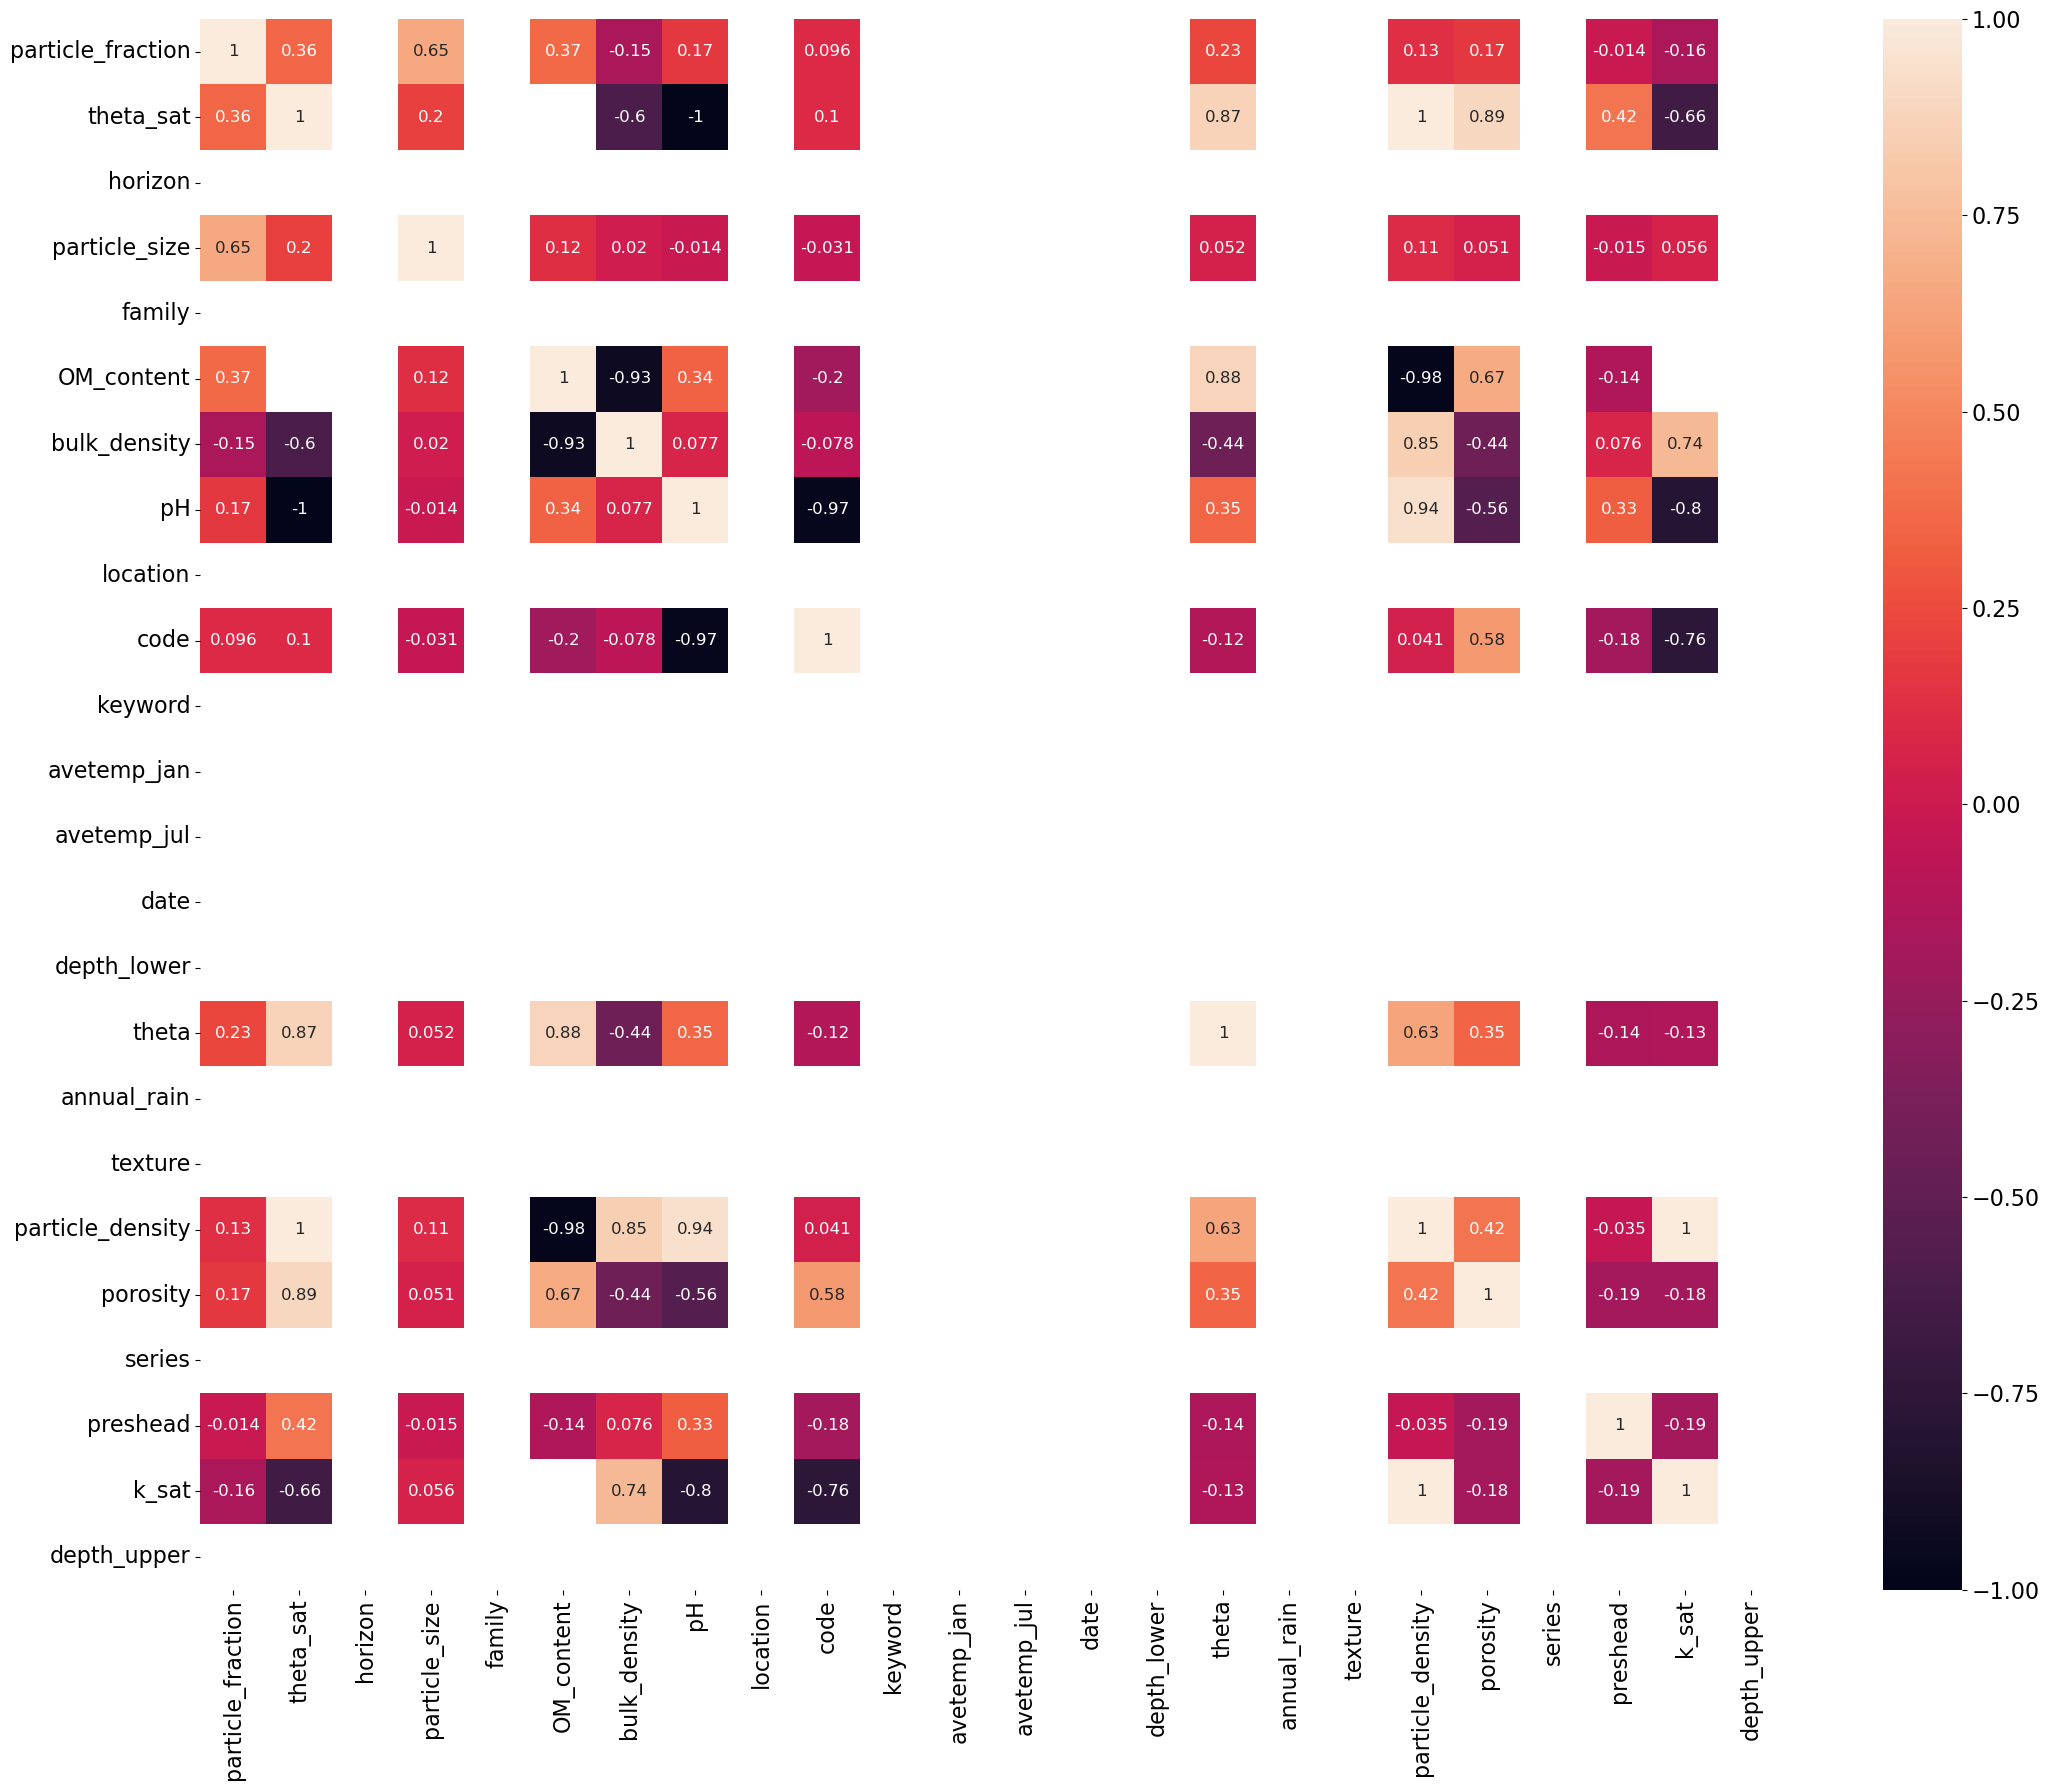

In [290]:

## since we are predicting wrc, we check correlation with phead and theta, too messy so we fix it.
import seaborn as sns    
plt.figure(figsize=(22,18))
sns_plt = sns.heatmap(wet_data_encoded.corr(), annot=True, annot_kws={"fontsize":12})
if SAVE_FIGS:
    plt.savefig("fig_corr_wrc_wet.png")
    
else:
    plt.show()
plt.show()
plt.close()

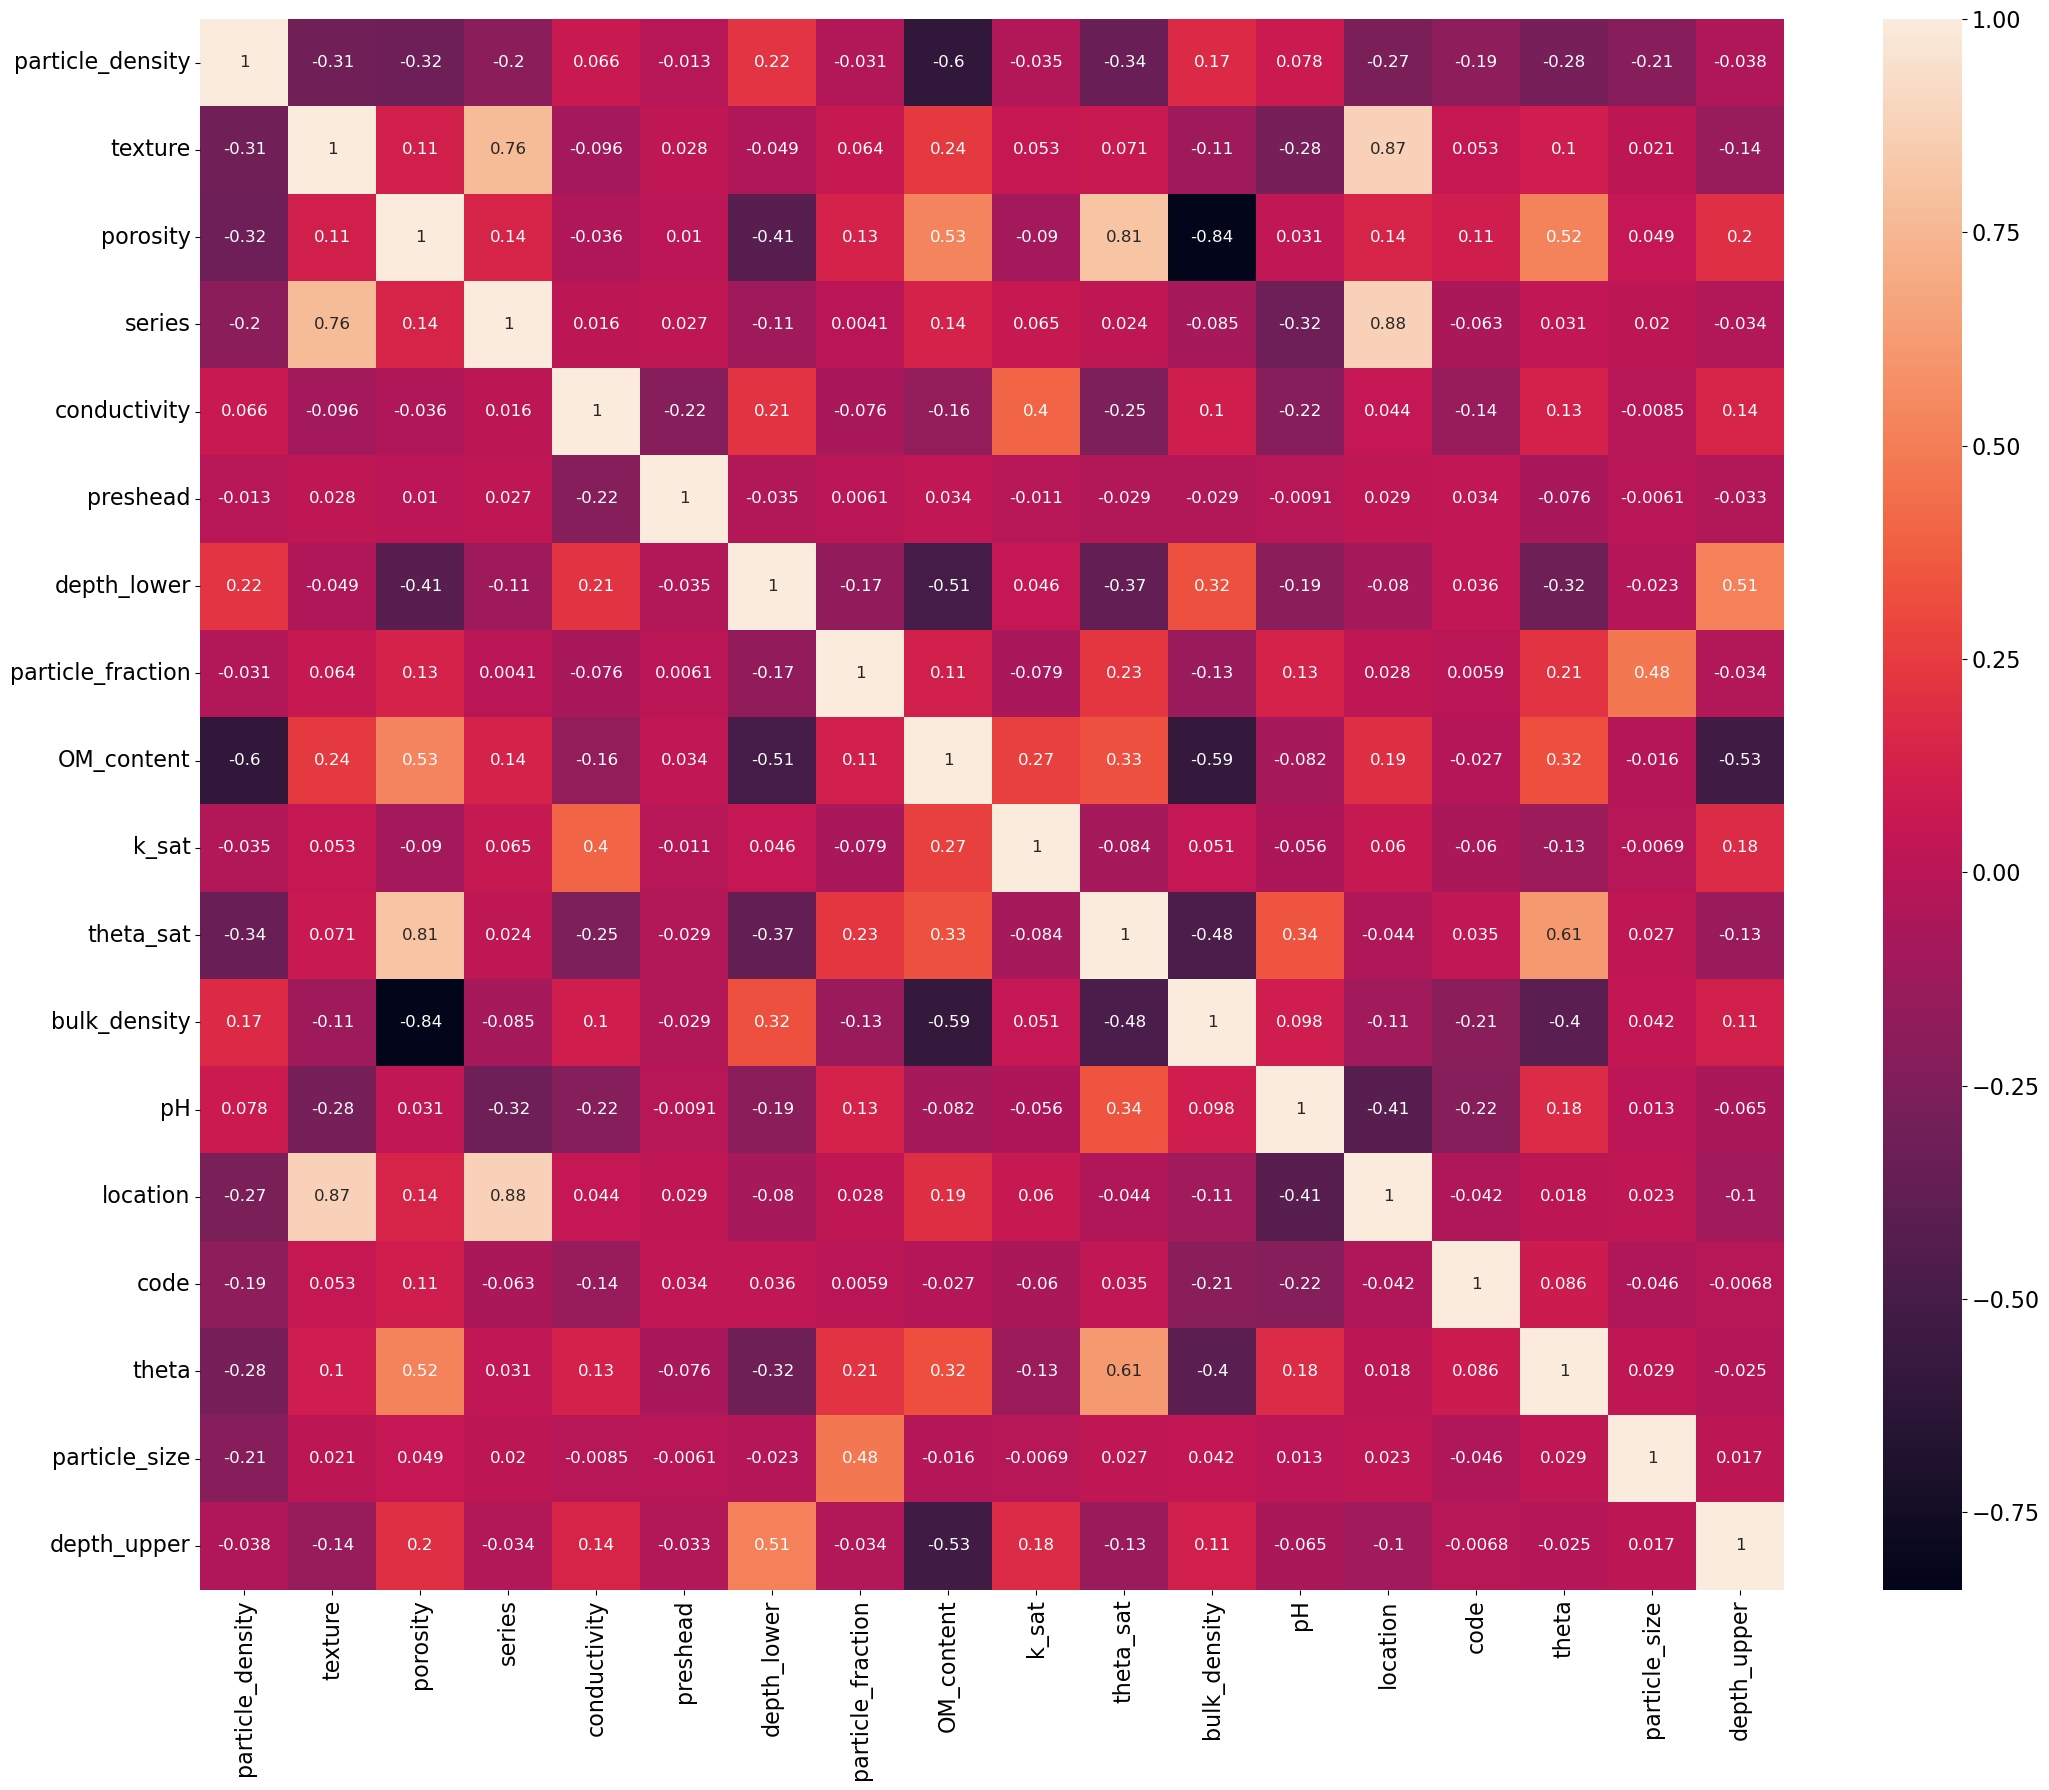

In [291]:

## since we are predicting wrc, we check correlation with phead and theta, too messy so we fix it.
import seaborn as sns    
plt.figure(figsize=(22,18))
sns_plt = sns.heatmap(dry_data_encoded.corr(), annot=True, annot_kws={"fontsize":12})
if SAVE_FIGS:
    plt.savefig("fig_corr_wrc_dry.png")
    
else:
    plt.show()
plt.show()
plt.close()

In [292]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

num_imputer = SimpleImputer(strategy='median')


dry_data_encoded[list(data_drying_filtered)] = num_imputer.fit_transform(dry_data_encoded[list(data_drying_filtered)])

dry_data_encoded.isna().value_counts()

particle_density  texture  porosity  series  conductivity  preshead  depth_lower  particle_fraction  OM_content  k_sat  theta_sat  bulk_density  pH     location  code   theta  particle_size  depth_upper
False             False    False     False   False         False     False        False              False       False  False      False         False  False     False  False  False          False          64786
Name: count, dtype: int64

In [301]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

num_imputer = SimpleImputer(strategy='median')

valid_columns = [col for col in list(data_wetting_filtered) if wet_data_encoded[col].notna().any()]

wet_data_encoded[valid_columns] = num_imputer.fit_transform(wet_data_encoded[valid_columns])

wet_data_encoded.dropna(axis=1, inplace=True)

print(wet_data_encoded.isna().sum())


particle_fraction    0
theta_sat            0
horizon              0
particle_size        0
family               0
OM_content           0
bulk_density         0
pH                   0
location             0
code                 0
keyword              0
date                 0
theta                0
texture              0
particle_density     0
porosity             0
series               0
preshead             0
k_sat                0
dtype: int64


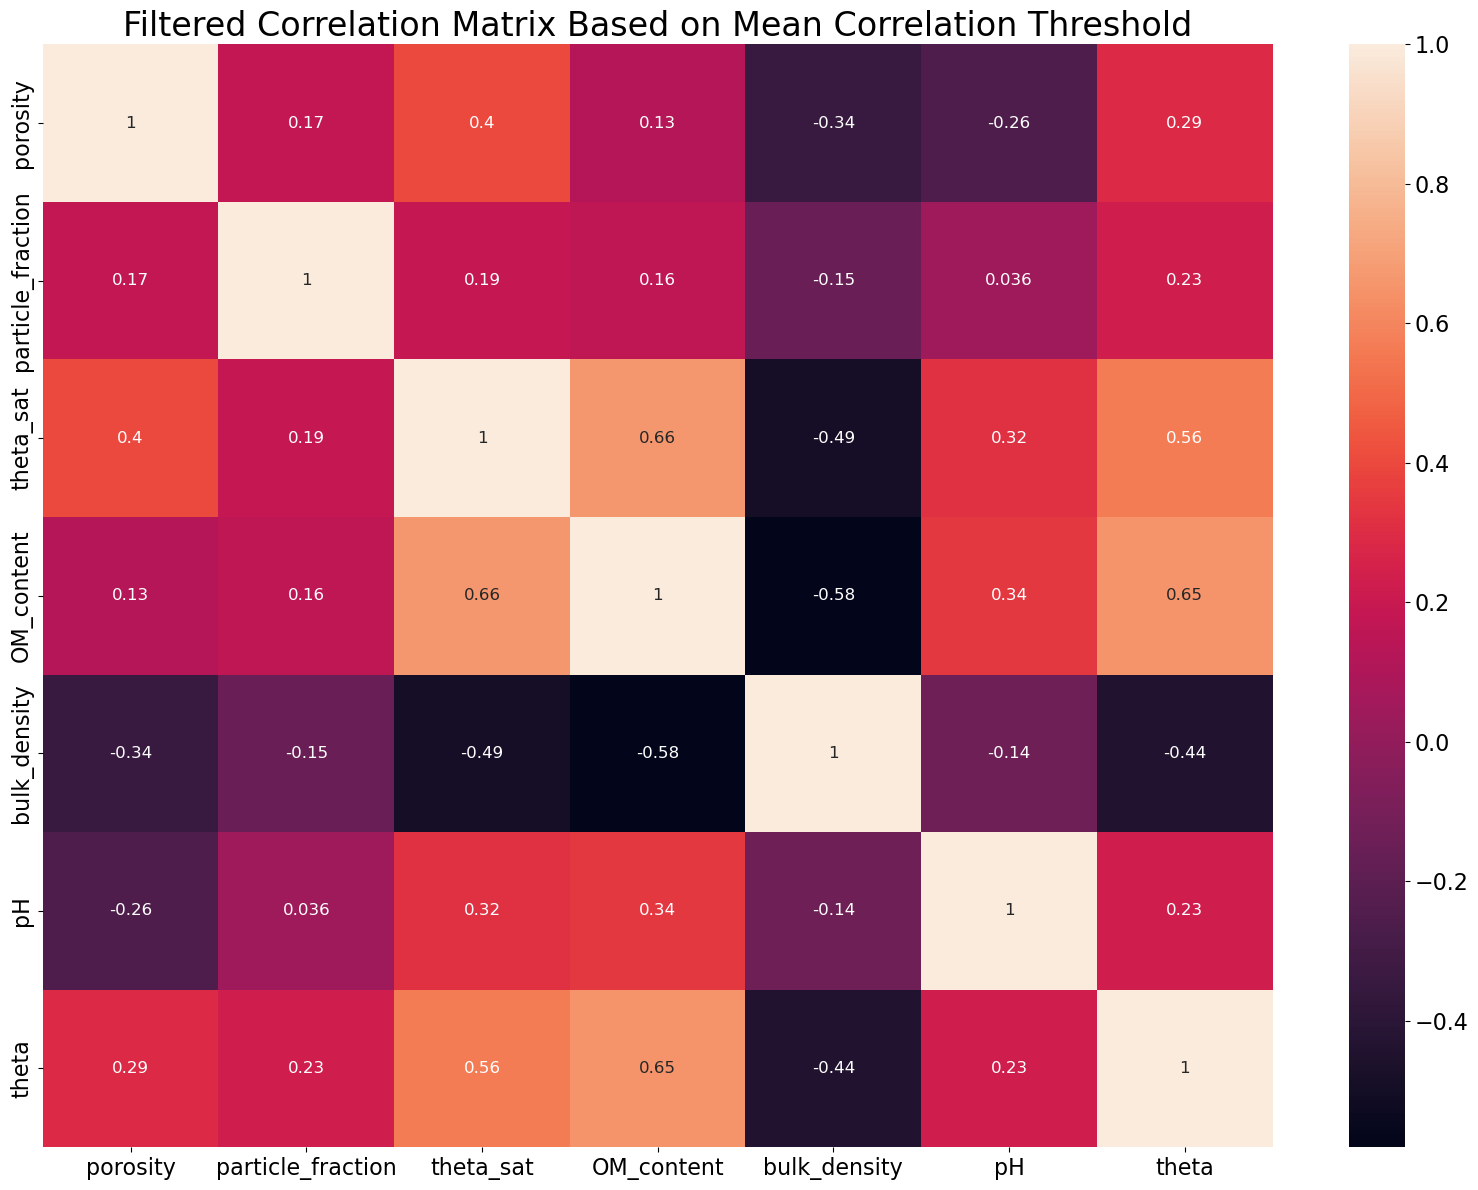

In [302]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = wet_data_encoded.corr()


mean_corr = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().mean()

high_corr_with_theta = corr_matrix.index[(corr_matrix["theta"].abs() > mean_corr) & (corr_matrix.index != 'theta')]

cols_to_keep_wet =  set(high_corr_with_theta)
cols_to_keep_wet.update(['theta'])  


filtered_data = wet_data_encoded[list(cols_to_keep_wet)]

plt.figure(figsize=(16, 12))
sns.heatmap(filtered_data.corr(), annot=True, annot_kws={"fontsize":12})
plt.title("Filtered Correlation Matrix Based on Mean Correlation Threshold")

if SAVE_FIGS:
    plt.savefig("fig_corr_wrc_filtered_mean_threshold_wet.png")
else:
    plt.show()
plt.show()
plt.close()


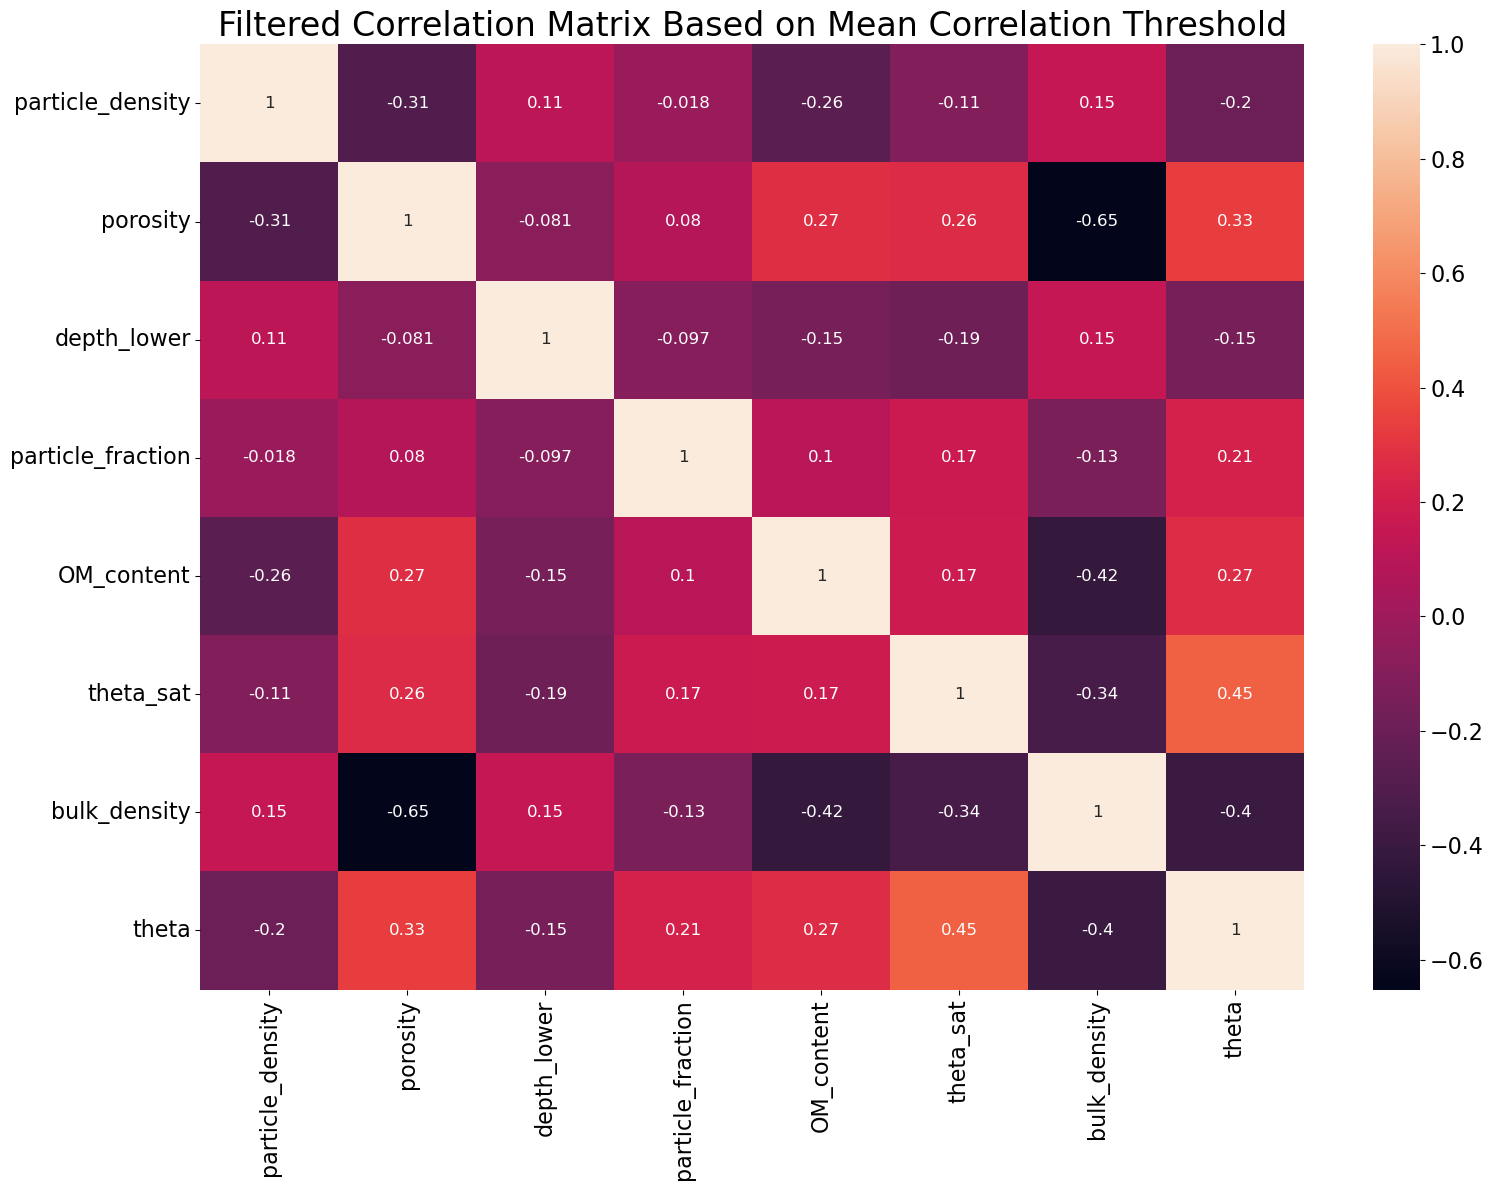

In [303]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = dry_data_encoded.corr()


mean_corr = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().mean()

high_corr_with_theta = corr_matrix.index[(corr_matrix["theta"].abs() > mean_corr) & (corr_matrix.index != 'theta')]

cols_to_keep_dry =  set(high_corr_with_theta)
cols_to_keep_dry.update(['theta'])  


filtered_data = dry_data_encoded[list(cols_to_keep_dry)]

plt.figure(figsize=(16, 12))
sns.heatmap(filtered_data.corr(), annot=True, annot_kws={"fontsize":12})
plt.title("Filtered Correlation Matrix Based on Mean Correlation Threshold")

if SAVE_FIGS:
    plt.savefig("fig_corr_wrc_filtered_mean_threshold_dry.png")
else:
    plt.show()
plt.show()
plt.close()


In [304]:
cols_to_keep_wet == cols_to_keep_dry

False

In [305]:
## we add teacher features that he used : k_sat, preshead, partifcle_size, particle_fraction, porosity, bulk,density, theta but they all already exist

In [306]:
def remove_outliers(df, columns):

    for column in columns:
        if df[column].dtype in ['float64', 'int64']:  
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

columns_to_check_for_outliers_wet = list(cols_to_keep_wet)  
columns_to_check_for_outliers_dry = list(cols_to_keep_dry)

dry_data_no_outliers = remove_outliers(dry_data_encoded, columns_to_check_for_outliers_dry)

wet_data_no_outliers = remove_outliers(wet_data_encoded, columns_to_check_for_outliers_wet)

In [307]:
def create_gsd_features_and_remove_contributors(df_wrc):

    gsd_names = ['P2', 'P50', 'P100', 'P250', 'P500', 'P1000', 'P2000']
    gsd_points = pd.Series([0.002, 0.05, 0.1, 0.25, 0.5, 1, 2])
    selec_len = df_wrc[df_wrc.code.isin(codes)].preshead.count()

    df_select = pd.DataFrame(
        index=np.arange(selec_len), columns=['code'] + gsd_names + ['rho', 'suction', 'theta']
    )

    icount = 0
    for icode in codes:
        tmp1 = df_wrc.loc[df_wrc.code.isin([icode]),['preshead', 'theta']]
        if tmp1.count()['preshead'] != tmp1.count()['theta']:
            sys.exit("Length mismatch in wrc")
        tmp2 = df_gsd.loc[(df_gsd.code.isin([icode])),['particle_size', 'particle_fraction']]
        if tmp2.count()['particle_size'] != tmp2.count()['particle_fraction']:
            sys.exit("Length mismatch in gsd")
        if (tmp1.count()['preshead'] > 0) and (tmp2.particle_size.count() > 0):
            if (tmp2.particle_size.size != 7) or ((tmp2.particle_size.size == 7) and ((tmp2.particle_size.values != gsd_points.values).any())):
                f = interpolate.interp1d(tmp2.particle_size,tmp2.particle_fraction,
                                            bounds_error=False,fill_value=(0.,1.))
                tmp2 = pd.DataFrame(
                    {
                    'particle_size': gsd_points.values,
                    'particle_fraction': f(gsd_points),
                    }
                )        
            for iwrc in range(tmp1.count()['preshead']):
                df_select.at[icount,'code'] = icode
                for ipoints in range(len(gsd_names)):
                    tmp = tmp2[tmp2.particle_size == gsd_points[ipoints]].particle_fraction
                    if len(tmp) > 0:
                        df_select.at[icount,gsd_names[ipoints]] = tmp.values[0]
                tmp = df_soil[df_soil.code.isin([icode])].bulk_density
                if len(tmp) > 0:
                    df_select.at[icount,'rho'] = tmp.values[0]
                if len([tmp1.preshead.values[iwrc]]) > 0:
                    df_select.at[icount,'suction'] = tmp1.preshead.values[iwrc]
                if len([tmp1.theta.values[iwrc]]) > 0:
                    df_select.at[icount,'theta'] = tmp1.theta.values[iwrc]
                icount += 1
                
    return df_select

In [308]:
dry_data_with_gsd_features = create_gsd_features_and_remove_contributors(dry_data_no_outliers)

In [309]:
wet_data_with_gsd_features = create_gsd_features_and_remove_contributors(wet_data_no_outliers)

In [310]:
wet_data_with_gsd_features.head()

,code,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta
0,1310,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,113.0,0.043
1,1310,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,113.0,0.043
2,1310,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,113.0,0.043
3,1310,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,38.0,0.133
4,1310,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,38.0,0.133


In [311]:
dry_data_with_gsd_features.head()

,code,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta
0,1020,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
1,1020,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
2,1020,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
3,1020,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
4,1020,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122


In [312]:
def add_columns_before_theta(original_df, gsd_features_df, exclude_columns):

    columns_to_add = [col for col in original_df.columns if col not in exclude_columns and col not in gsd_features_df.columns]
    
    merged_df = pd.DataFrame()
    
    for col in columns_to_add:
        merged_df[col] = original_df[col]
    

    final_df = pd.concat([merged_df.reset_index(drop=True), gsd_features_df.reset_index(drop=True)], axis=1)
    
    return final_df

In [313]:
exclude_columns = ['theta', 'bulk_density', 'particle_size', 'particle_fraction', 'preshead']

wet_data_final = add_columns_before_theta(wet_data_no_outliers, wet_data_with_gsd_features, exclude_columns)

dry_data_final = add_columns_before_theta(dry_data_no_outliers, dry_data_with_gsd_features, exclude_columns)

In [314]:
wet_data_final.head()

,theta_sat,horizon,family,OM_content,pH,location,keyword,date,texture,particle_density,...,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta
0,0.503,0.0,0.0,0.885,4.183,0.0,0.0,0.0,0.0,2.634,...,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,113.0,0.043
1,0.503,0.0,0.0,0.885,4.183,0.0,0.0,0.0,0.0,2.634,...,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,113.0,0.043
2,0.503,0.0,0.0,0.885,4.183,0.0,0.0,0.0,0.0,2.634,...,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,113.0,0.043
3,0.503,0.0,0.0,0.885,4.183,0.0,0.0,0.0,0.0,2.634,...,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,38.0,0.133
4,0.503,0.0,0.0,0.885,4.183,0.0,0.0,0.0,0.0,2.634,...,0.02,0.044,0.068513,0.142051,0.264615,0.509744,1.0,1.6,38.0,0.133


In [315]:
dry_data_final.head()

,particle_density,texture,porosity,series,conductivity,depth_lower,OM_content,k_sat,theta_sat,pH,...,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta
0,2.65,12.0,0.44,33.0,1.656,61.0,0.75,88.992,0.418,7.3,...,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
1,2.65,12.0,0.44,33.0,1.656,61.0,0.75,88.992,0.418,7.3,...,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
2,2.65,12.0,0.44,33.0,1.656,61.0,0.75,88.992,0.418,7.3,...,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
3,2.65,12.0,0.44,33.0,1.656,61.0,0.75,88.992,0.418,7.3,...,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122
4,2.65,12.0,0.44,33.0,1.656,61.0,0.75,88.992,0.418,7.3,...,0.045,0.1,0.121,0.173,0.2,0.804,0.997,1.61,122.0,0.122


In [316]:
dry_data_final.drop_duplicates(inplace=True)
wet_data_final.drop_duplicates(inplace=True)

In [317]:
dry_data_final.to_csv(r'my_final_dry_data.csv', index=False, header=True)

In [318]:
wet_data_final.to_csv(r'my_final_wet_data.csv', index=False, header=True)

In [319]:
dry_data_final[dry_data_final.code == CODE]

,particle_density,texture,porosity,series,conductivity,depth_lower,OM_content,k_sat,theta_sat,pH,...,P2,P50,P100,P250,P500,P1000,P2000,rho,suction,theta


In [320]:
print(dry_data_final.code)

0        1020
7        1020
14       1020
21       1020
28       1020
         ... 
10942     NaN
11062     NaN
11238     NaN
11558     NaN
11646     NaN
Name: code, Length: 761, dtype: object


<Axes: xlabel='Pressure (kPa)', ylabel='Volumetric water content (-)'>

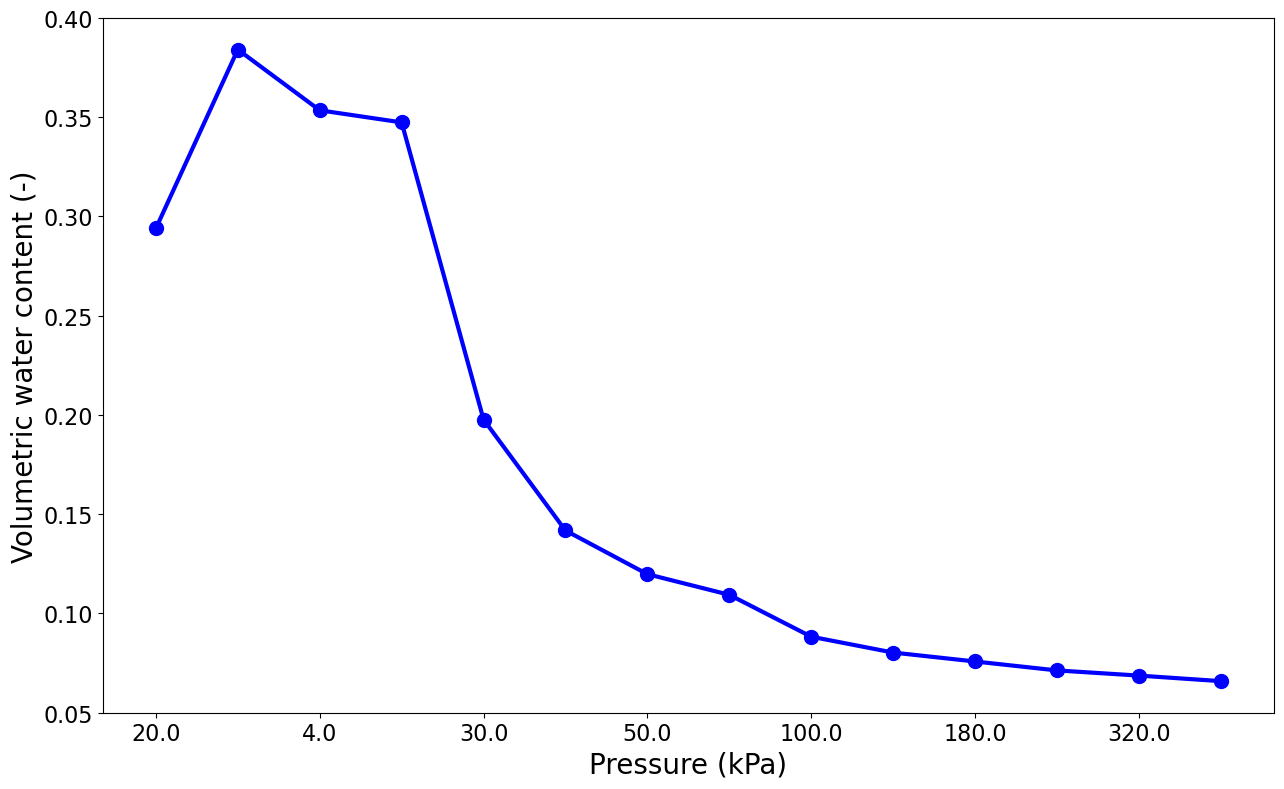

In [321]:
CODE = 1050

dry_data_final[dry_data_final.code == CODE].plot(x="suction", y="theta", style='-bo', legend=False, xlabel="Pressure (kPa)", ylabel="Volumetric water content (-)")

In [322]:
conn.close()
